# Chest X-Ray Images (Pneumonia) Classification

### Introduction
By Ziv Ben Zvi 203966643 and Julian Rubinstein 204907901.

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.
Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases. Diagnosis is often based on symptoms and physical examination. Chest X-rays, blood tests, and culture of the sputum may help confirm the diagnosis.

As mentioned above, a chest X-ray is a prominent and common way to identify pneumonia. Therefore, developing an accurate model for analyzing the results of a chest X-ray can be extremly helpful in succesfuly diagnosing pneumonia in patients. The following paper will discuss the development of such model and its subsuquent accuracy and efficacy in acomplishing this task. The learning proccess of this model uses the dataset provided in the kaggle competition [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/discussion) and will attempt to classify X-ray lung images to either normal or pneumonia. The dataset contains 5,840 chest X-Ray RGB images (JPEG) divided into NORMAL or PNEUMONIA folders.

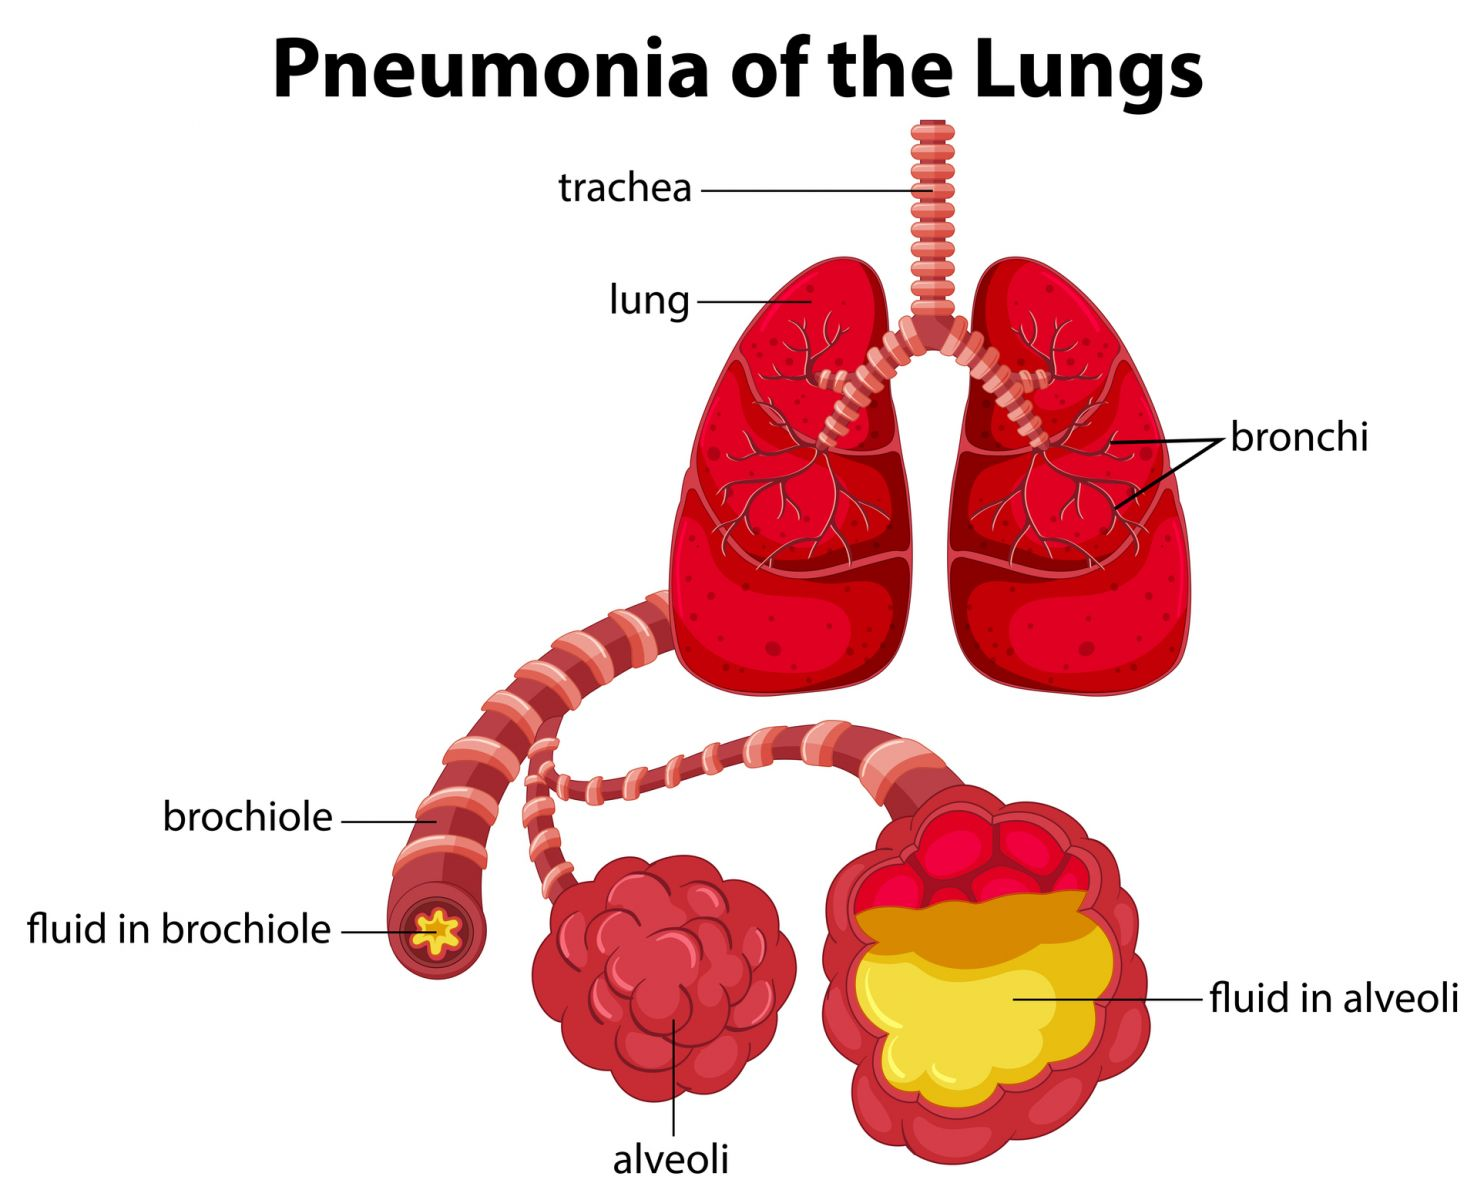

### Imports

In [2]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import cv2

In [3]:
import sklearn
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import class_weight
import shap

### Loading Data and Data Processing

We define the data paths, compress the images by resizing them and then load the data to a list of 2d np arrays which represnt the images:

In [4]:
#NORMAL_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/NORMAL'
#PNEUMONIA_PATH = 'F:\Dropbox\Studies\Computer Science\DSseminar\DSFinalProject\Spyder\chest_xray/DATA/PNEUMONIA'
NORMAL_PATH = 'chest_xray/DATA/NORMAL'
PNEUMONIA_PATH = 'chest_xray/DATA/PNEUMONIA'

NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

normal_data = []
pneumonia_data = []

for file in tqdm(NORMAL_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    normal_data.append(image)

for file in tqdm(PNEUMONIA_FILES):
    image = cv2.imread(file)
    image = cv2.resize(image, (100,60))
    pneumonia_data.append(image)

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/4265 [00:00<?, ?it/s]

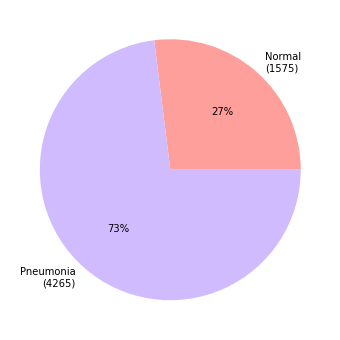

In [5]:
data = [len(normal_data), len(pneumonia_data)]
labels = [f'Normal\n({len(normal_data)})', f'Pneumonia\n({len(pneumonia_data)})']

plt.rcParams["figure.figsize"] = (10,6)
colors = sns.color_palette('pastel')[3:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')

plt.show()

In [137]:
print("Normal single image shape: " + str(normal_data[0].shape))
print("Pneumonia single image shape: " + str(pneumonia_data[0].shape))

Normal single image shape: (60, 100, 3)
Pneumonia single image shape: (60, 100, 3)


Two things can be observed - Firstly, the shape of the images is 60X100X3, as expected following the compression done above and the fact the images are all RGB images. Secondly, we can see that the data contains approximatly 3 times the amount of pneumonia images to normal images, that is something that should be taken note of as it can affect the training of future models.

Next, in observing the images, it can be noticed that although the images are in RGB format, all the colors appear to be entirely greyscaled. In the following blocks of code we will check the possibility of converting the images to greyscale to both reduce the file-size of the images (which will make the model training faster) and to reduce the complexity of the images which will ease the process of image analysis.

Firstly, lets observe an image before and after converting it to greyscale format:

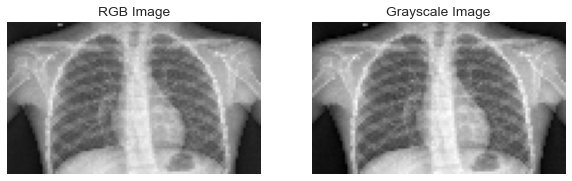

In [138]:
normal_image = normal_data[0]
gray_image = cv2.cvtColor(normal_image, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,2)

ax[0].imshow(normal_image)
ax[0].set_title('RGB Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[1].axis('off')

plt.show()

In [139]:
print("Before conversion shape: " + str(normal_data[0].shape))
print("After conversion shape: " + str(gray_image.shape))

Before conversion shape: (60, 100, 3)
After conversion shape: (60, 100)


As expected, it can be clearly seen that the conversion to grayscale hardly affects the visual of the image, if at all. As such, we will proceed to convert all images to grayscale format:

Grayscale-like images are images in which all three RGB colors have similar values. For example - (0,0,0) would be black, (128,128,128) would be grey, and (255,255,255) would be white. On the other hand, (22,166,41) would be dark green. To prove that in approximation all images are grayscale-like, we would like to show that all image cells have approximatly the same value, i.e, low variance.

Lets calculate the standard deviation of every image in the data and calculate the average standard deviations of all images.

# FIX BELOW

In [ ]:
NUM_OF_PIXELS = 100*60

standard_deviations = []
sum = 0


for i in tqdm(range(len(normal_data))):
    for row in normal_data[i]:
        for cell in row:
            average = cell.mean()
            deviation = int(cell[0]) + int(cell[1]) + int(cell[2]) - 3 * average
            sum += deviation
            
    standard_deviations.append(sum/NUM_OF_PIXELS)

print("The average standard deviation of all images is: " + str(np.asarray(standard_deviations).mean()))

As can be seen, all images are purely grayscale, as the standard deviation of all cells is preciesly zero. Therefore, we will proceed to convert all images to grayscale format:

In [6]:
for index, image in enumerate(normal_data):
    normal_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

### EDA

Firstly, lets define this section functions:

In [143]:
def plot_images(normal_img, pneumonia_img, plot_color):    
    fig, axis = plt.subplots(2,4)
    plt.rcParams["figure.figsize"] = (15,7)

    for index, image in enumerate(normal_img[:4]):
        axis[0,index].imshow(image, cmap=plot_color)
        axis[0,index].set_title('Normal')
        
    for index, image in enumerate(pneumonia_img[:4]):
        axis[1,index].imshow(image, cmap=plot_color)
        axis[1,index].set_title('Pneumonia')

    plt.show()
    
def plot_pixel_values(normal_img, pneumonia_img):
    
    normal_mean = int(np.mean(normal_img))
    pneumonia_mean = int(np.mean(pneumonia_img))

    normal_median = int(np.median(normal_img))
    pneumonia_median = int(np.median(pneumonia_img))

    normal_std = int(np.std(normal_img))
    pneumonia_std = int(np.std(pneumonia_img))
    
    df  = pd.DataFrame({"method" : ["average", "average", "median", "median", "standard deviation", "standard deviation"],
                    "value" : [normal_mean, pneumonia_mean, normal_median, pneumonia_median, normal_std, pneumonia_std],
                    "condition" : ["normal", "pneumonia", "normal", "pneumonia", "normal", "pneumonia"]},
                    index = [1, 2, 3, 4, 5, 6])

    plt.rcParams["figure.figsize"] = (15,7)
    plot = sns.catplot(
        data=df, kind="bar",
        x="method", y="value", hue="condition",
        ci="None", palette="dark", alpha=.6, height=6
    )
    plot.despine(left=True)
    plot.set_axis_labels("", "Pixel values")
    
    sns.set(font_scale=1.15)
   
    
def plot_color_distribution(normal_img, pneumonia_img):
    normal_dist = pneumonia_dist = 0
    normal_dist_flattened = []
    pneumonia_dist_flattened = []

    # calculate distibution of normal images
    for image in normal_img:
        normal_dist_flattened.append(image.flatten())

    for image in normal_dist_flattened:
        normal_dist += image/len(normal_img)
        
    # calculate distibution of pneumonia images
    for image in pneumonia_img:
        pneumonia_dist_flattened.append(image.flatten())

    for image in pneumonia_dist_flattened:
        pneumonia_dist += image/len(pneumonia_img)
    
    # plot the results
    plt.rcParams["figure.figsize"] = (15,7)
    plt.subplot(1, 2, 1)
    plt.title('Normal')
    sns.histplot(normal_dist)

    plt.subplot(1, 2, 2)
    plt.title('Pneumonia')
    sns.histplot(pneumonia_dist)

As a first step, lets simply observe a number of images of healthy patients and sick patients to see if we can point out any visual difference.

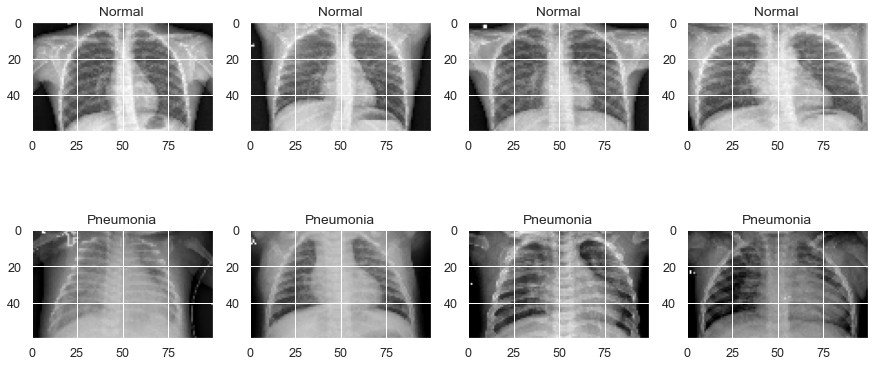

In [146]:
plot_images(normal_data, pneumonia_data, "gray")

By first examination, a slight difference of opacity within the ribcage can be noticed between the normal and the pneumonia-induced images. The pneumonia images appear to have a more cloudy color as opposed to the more transparent normal images (especially in the bottom left image that can be seen above).

Since these images are already converted to grey-scale, we can observe the single color distribution of the images and the mean pixel values:

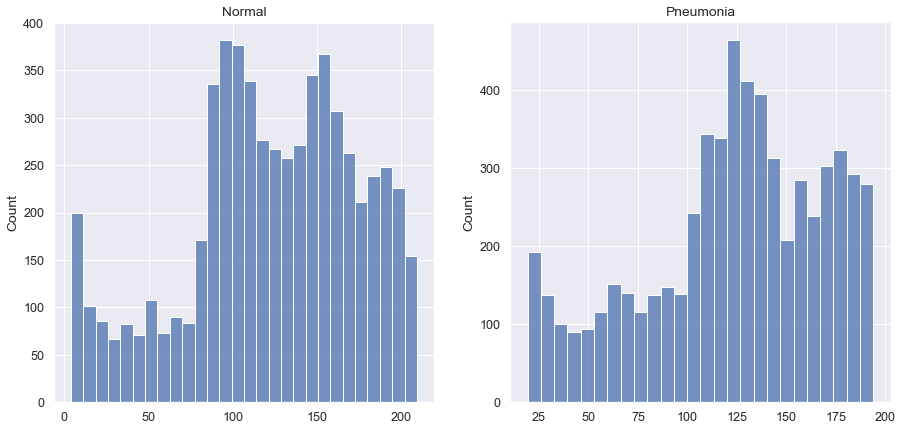

In [147]:
plot_color_distribution(normal_data,pneumonia_data)

A slight difference of shape between the distributions can be seen, however, nothing clear enough that can be pointed out without the use of more advanced tools. Lets observe the mean and median pixel values:

The mean pixel value of NORMAL images: 122
The mean pixel value of PNEUMONIA images: 122

The median pixel value of NORMAL images: 132
The median pixel value of PNEUMONIA images: 134

The standard deviation of the pixel value of NORMAL images: 62
The standard deviation of the pixel value of PNEUMONIA images: 59


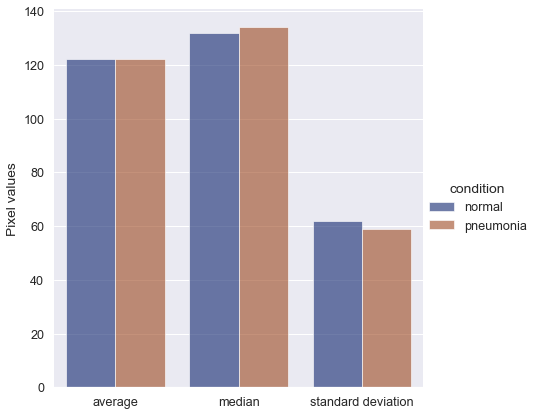

In [148]:
print(f"The mean pixel value of NORMAL images: {int(np.mean(normal_data))}")
print(f"The mean pixel value of PNEUMONIA images: {int(np.mean(pneumonia_data))}")

print(f"\nThe median pixel value of NORMAL images: {int(np.median(normal_data))}")
print(f"The median pixel value of PNEUMONIA images: {int(np.median(pneumonia_data))}")

print(f"\nThe standard deviation of the pixel value of NORMAL images: {int(np.std(normal_data))}")
print(f"The standard deviation of the pixel value of PNEUMONIA images: {int(np.std(pneumonia_data))}")\

plot_pixel_values(normal_data, pneumonia_data)

As can be clearly seen, the mean and median pixel values are extremly close and are well in the standard deviation of the pixel distribution. As such, this is not an avenue that will help the analysis.

### Feature extractions

In this part we would like to expand our knowledge and undarstanding of the data. For this matter, let's explore different methods of feature extraction and see if the data can provide us some insights.

The feature extraction methods that will be tested are:<br><br>1. Canny Edge detector - an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. <br><br>2. Background Subtraction - subtraction of background from images might produce intresting data. <br><br>3. Fourier Fast Transform(FFT) Method for Pixel Distribution - by moving the zero-frequency component to the center of the image. It is useful for visualizing a Fourier transform with the zero-frequency component in the middle of the spectrum, or in other words - this helps in understanding where majority of pixels is situated in a given image.<br><br>Let's get to work

##### Canny Edge detector

In [31]:
normal_edges = [0]*len(normal_data)
pneumonia_edges = [0]*len(pneumonia_data)

for i in range(len(normal_data)):
    normal_edges[i] = cv2.Canny(normal_data[i], 40, 100)

for j in range(len(pneumonia_data)):
    pneumonia_edges[j] = cv2.Canny(pneumonia_data[j], 40, 100)

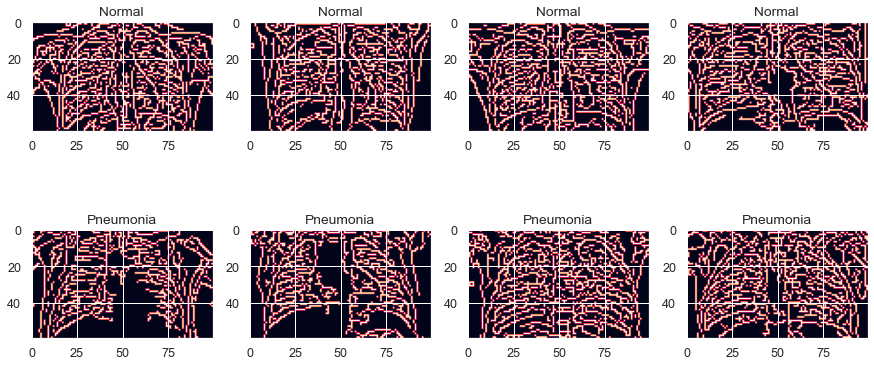

In [32]:
plot_images(normal_edges, pneumonia_edges, None)

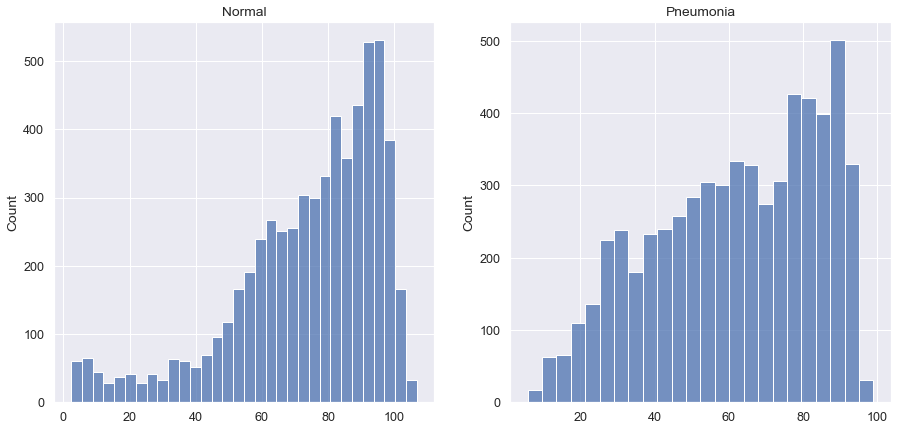

In [33]:
plot_color_distribution(normal_edges,pneumonia_edges)

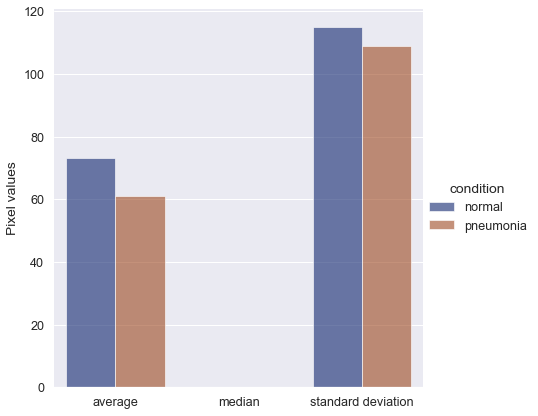

In [34]:
plot_pixel_values(normal_edges, pneumonia_edges)

Okay, it doesn't look like any insights can be made from what we see. The data is different when compared to the original images, but still when comparing normal to pneumonia there are no major differences. Let's try the next method.

##### Background Subtraction

In [35]:
fgbg = cv2.createBackgroundSubtractorMOG2()

normal_img = [0]*len(normal_data)
pneumonia_img = [0]*len(pneumonia_data)

for i in range(len(normal_data)):
    normal_img[i] = normal_data[i]
    normal_img[i] = cv2.cvtColor(normal_img[i], cv2.COLOR_GRAY2BGR)
    normal_img[i] = cv2.cvtColor(normal_img[i], cv2.COLOR_BGR2RGB)
    normal_img[i] = fgbg.apply(normal_img[i])
    
for j in range(len(pneumonia_data)):
    pneumonia_img[j] = pneumonia_data[j]
    pneumonia_img[j] = cv2.cvtColor(pneumonia_img[j], cv2.COLOR_GRAY2BGR)
    pneumonia_img[j] = cv2.cvtColor(pneumonia_img[j], cv2.COLOR_BGR2RGB)
    pneumonia_img[j] = fgbg.apply(pneumonia_img[j])


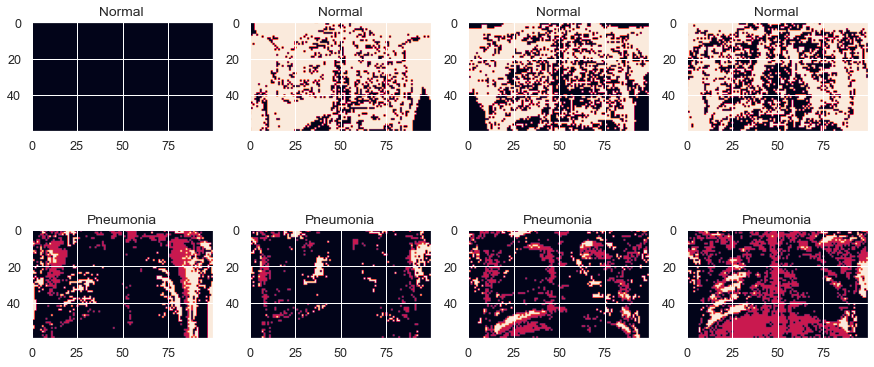

In [36]:
plot_images(normal_img, pneumonia_img, None)

Looks like our pneumonia images recieves a darker color, let's check the pixel values and distribution of the images:

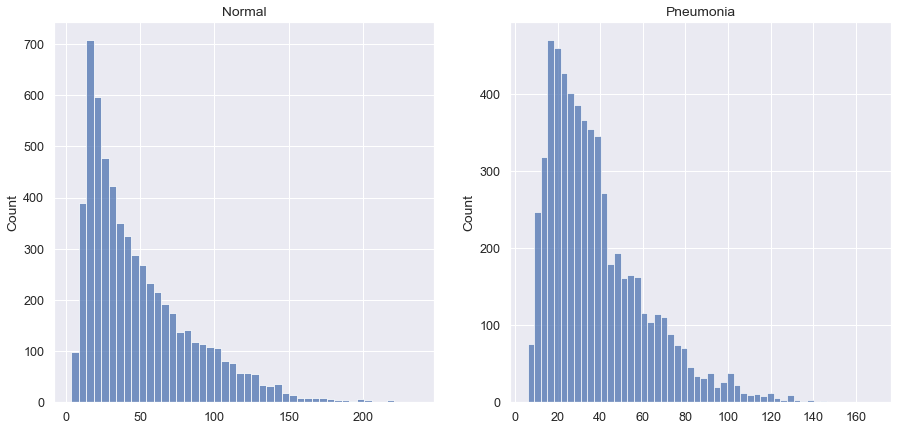

In [37]:
plot_color_distribution(normal_img, pneumonia_img)

This looks a bit different, but we realize the converted data is corrently in RGB format. Let's see if we can reveal something from RGB distribution:

In [ ]:
def plot_color_RGB_distribution(normal_img, pneumonia_img):
    def plot_hist_normed(images, channel, col):
        img_flattened = []
        img_dist = 0
        for img in images:
            img_flattened.append(img[:,channel].flatten())
        
        for image in img_flattened:
            img_dist += image/len(images)
        
        plt.ylabel(col)
        plt.hist(img_dist)
        plt.yticks([])
    
    
    #red  
    plt.figure(figsize =(40, 20))
    plt.subplot(2, 3, 1)
    plot_hist_normed(normal_img, 0, 'red')
    plt.title('normal')
    plt.subplot(2, 3, 4)
    plot_hist_normed(pneumonia_img, 0, 'red')
    plt.title('pneumonia')



    #green
    plt.subplot(2, 3, 2)
    plot_hist_normed(normal_img, 1, 'green')
    plt.title('normal')
    plt.subplot(2, 3, 5)
    plot_hist_normed(pneumonia_img, 1, 'green')
    plt.title('pneumonia')


    #blue
    plt.subplot(2, 3, 3)
    plot_hist_normed(normal_img, 2, 'blue')
    plt.title('normal')
    plt.subplot(2, 3, 6)
    plot_hist_normed(pneumonia_img, 2, 'blue')
    plt.title('pneumonia')

    plt.show()

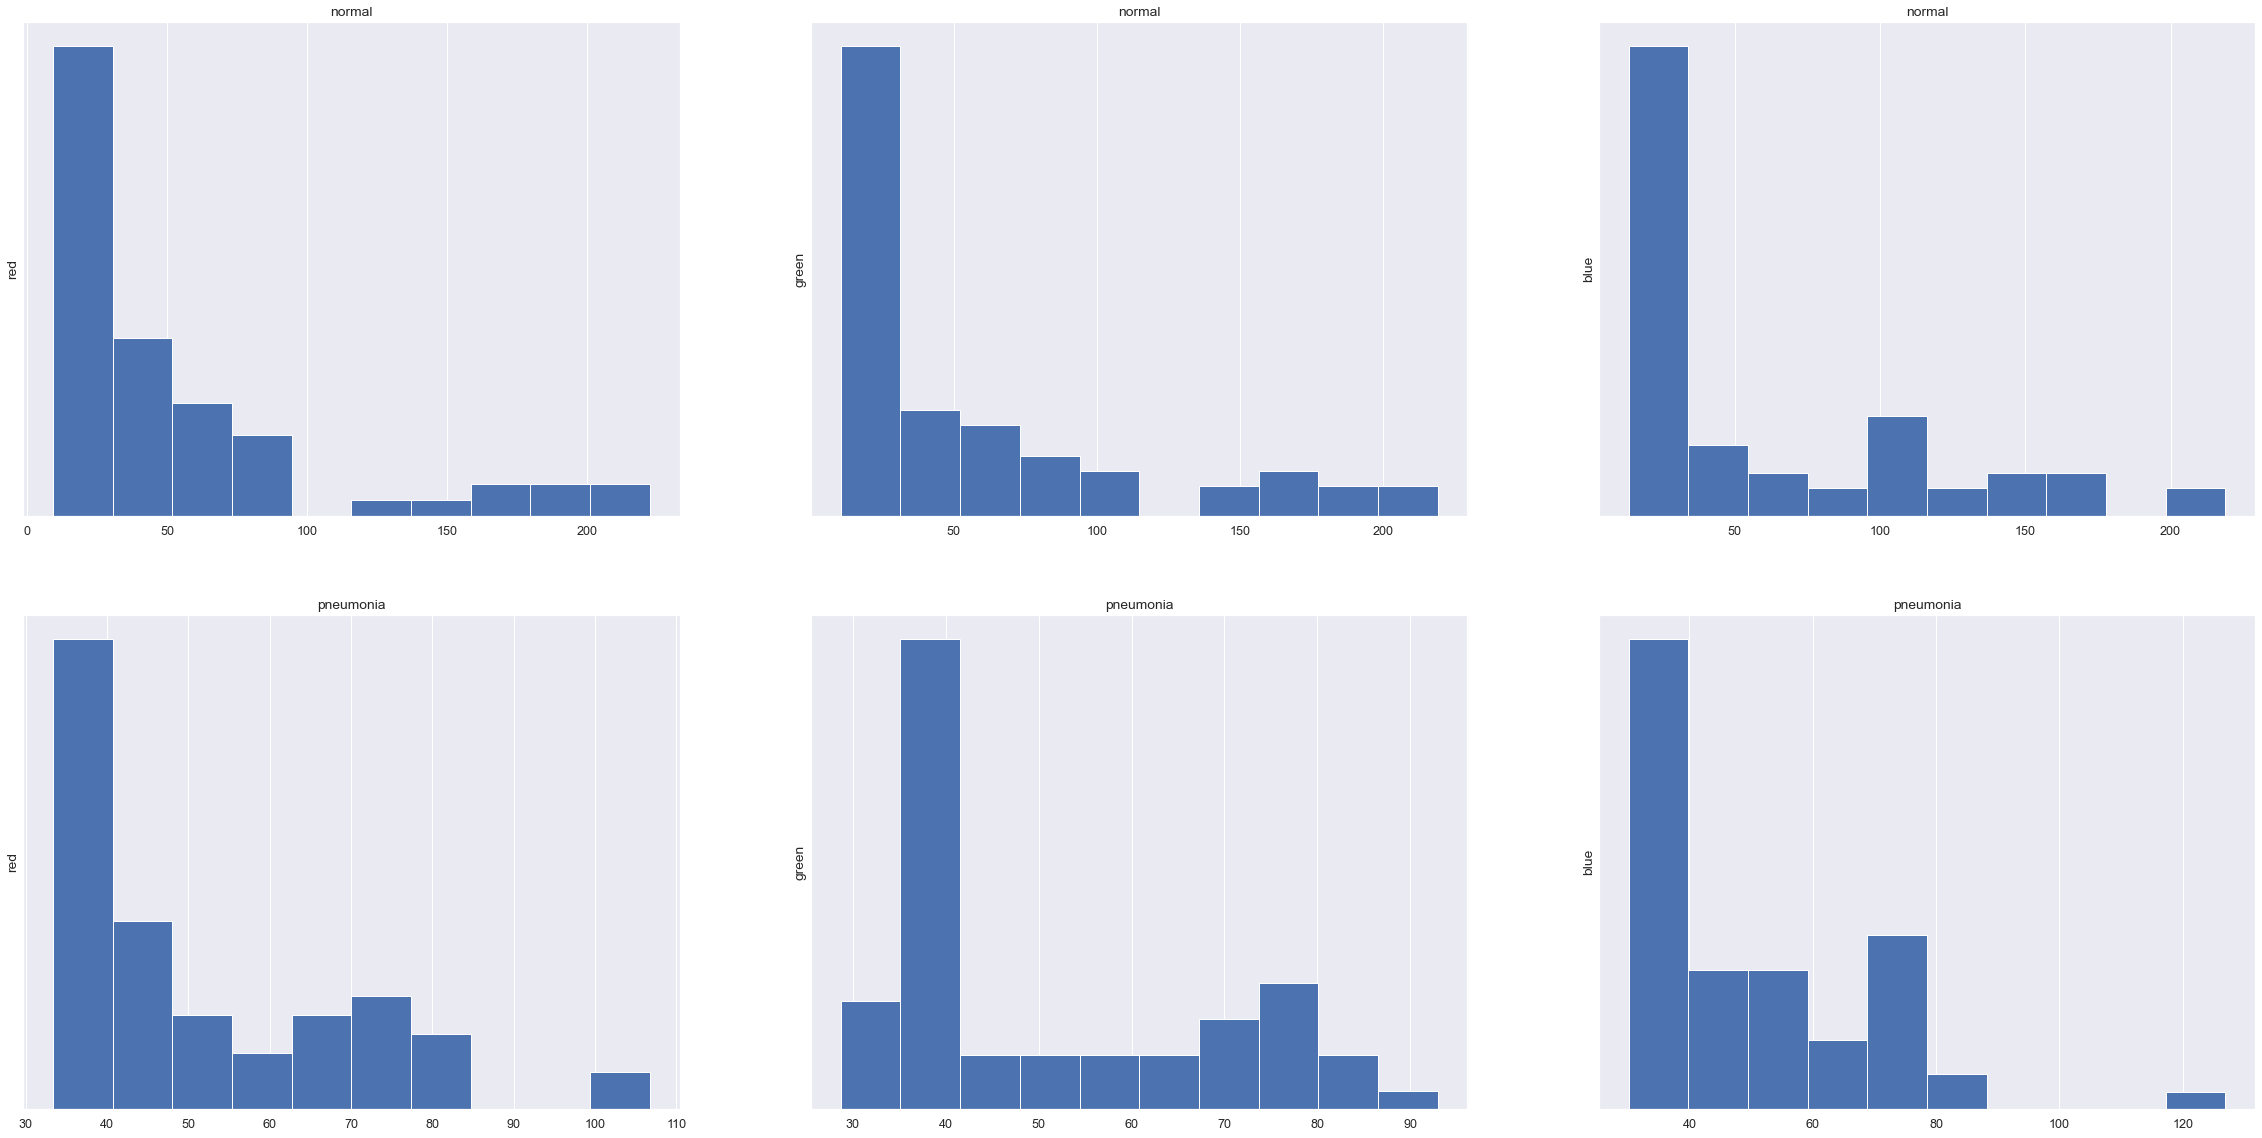

In [38]:
# plot description:
# 
# (    normal_red : normal_green : normal_blue     )
# (pneumonia_red : pneumonia_green : pneumonia_blue)

plot_color_RGB_distribution(normal_img, pneumonia_img)

Well the distribution seems very similar when comparing the colors and the conditions. 

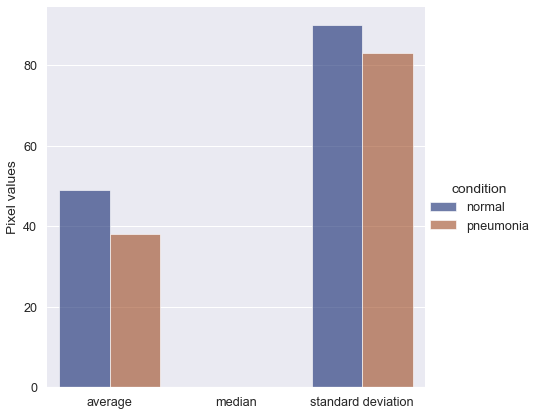

In [39]:
plot_pixel_values(normal_img, pneumonia_img)

This method didn't give us any insights eventhough it looked promising by examining the images at first. <br>Next method

##### Fourier Method for Pixel Distribution

In [40]:
normal_fft = [0]*len(normal_data)
pneumonia_fft = [0]*len(pneumonia_data)

for i in range(len(normal_data)):
    temp = np.fft.fft2(normal_data[i])
    magnitude_spectrum = 20*np.log(np.abs(np.fft.fftshift(temp)))
    normal_fft[i] = magnitude_spectrum

for j in range(len(pneumonia_data)):
    temp = np.fft.fft2(pneumonia_data[j])
    magnitude_spectrum = 20*np.log(np.abs(np.fft.fftshift(temp)))
    pneumonia_fft[j] = magnitude_spectrum

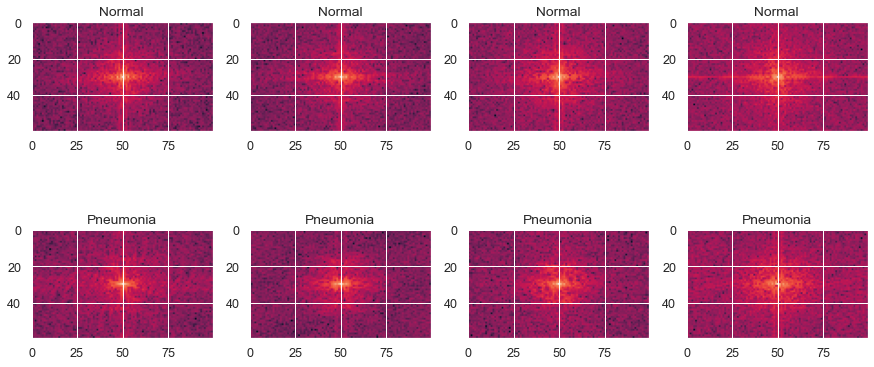

In [41]:
plot_images(normal_fft, pneumonia_fft, None)

You might think that it's just a bunch of red dots, but it's more than that.
Like we wrote earlier, this helps in understanding where majority of pixels is situated in a given image.

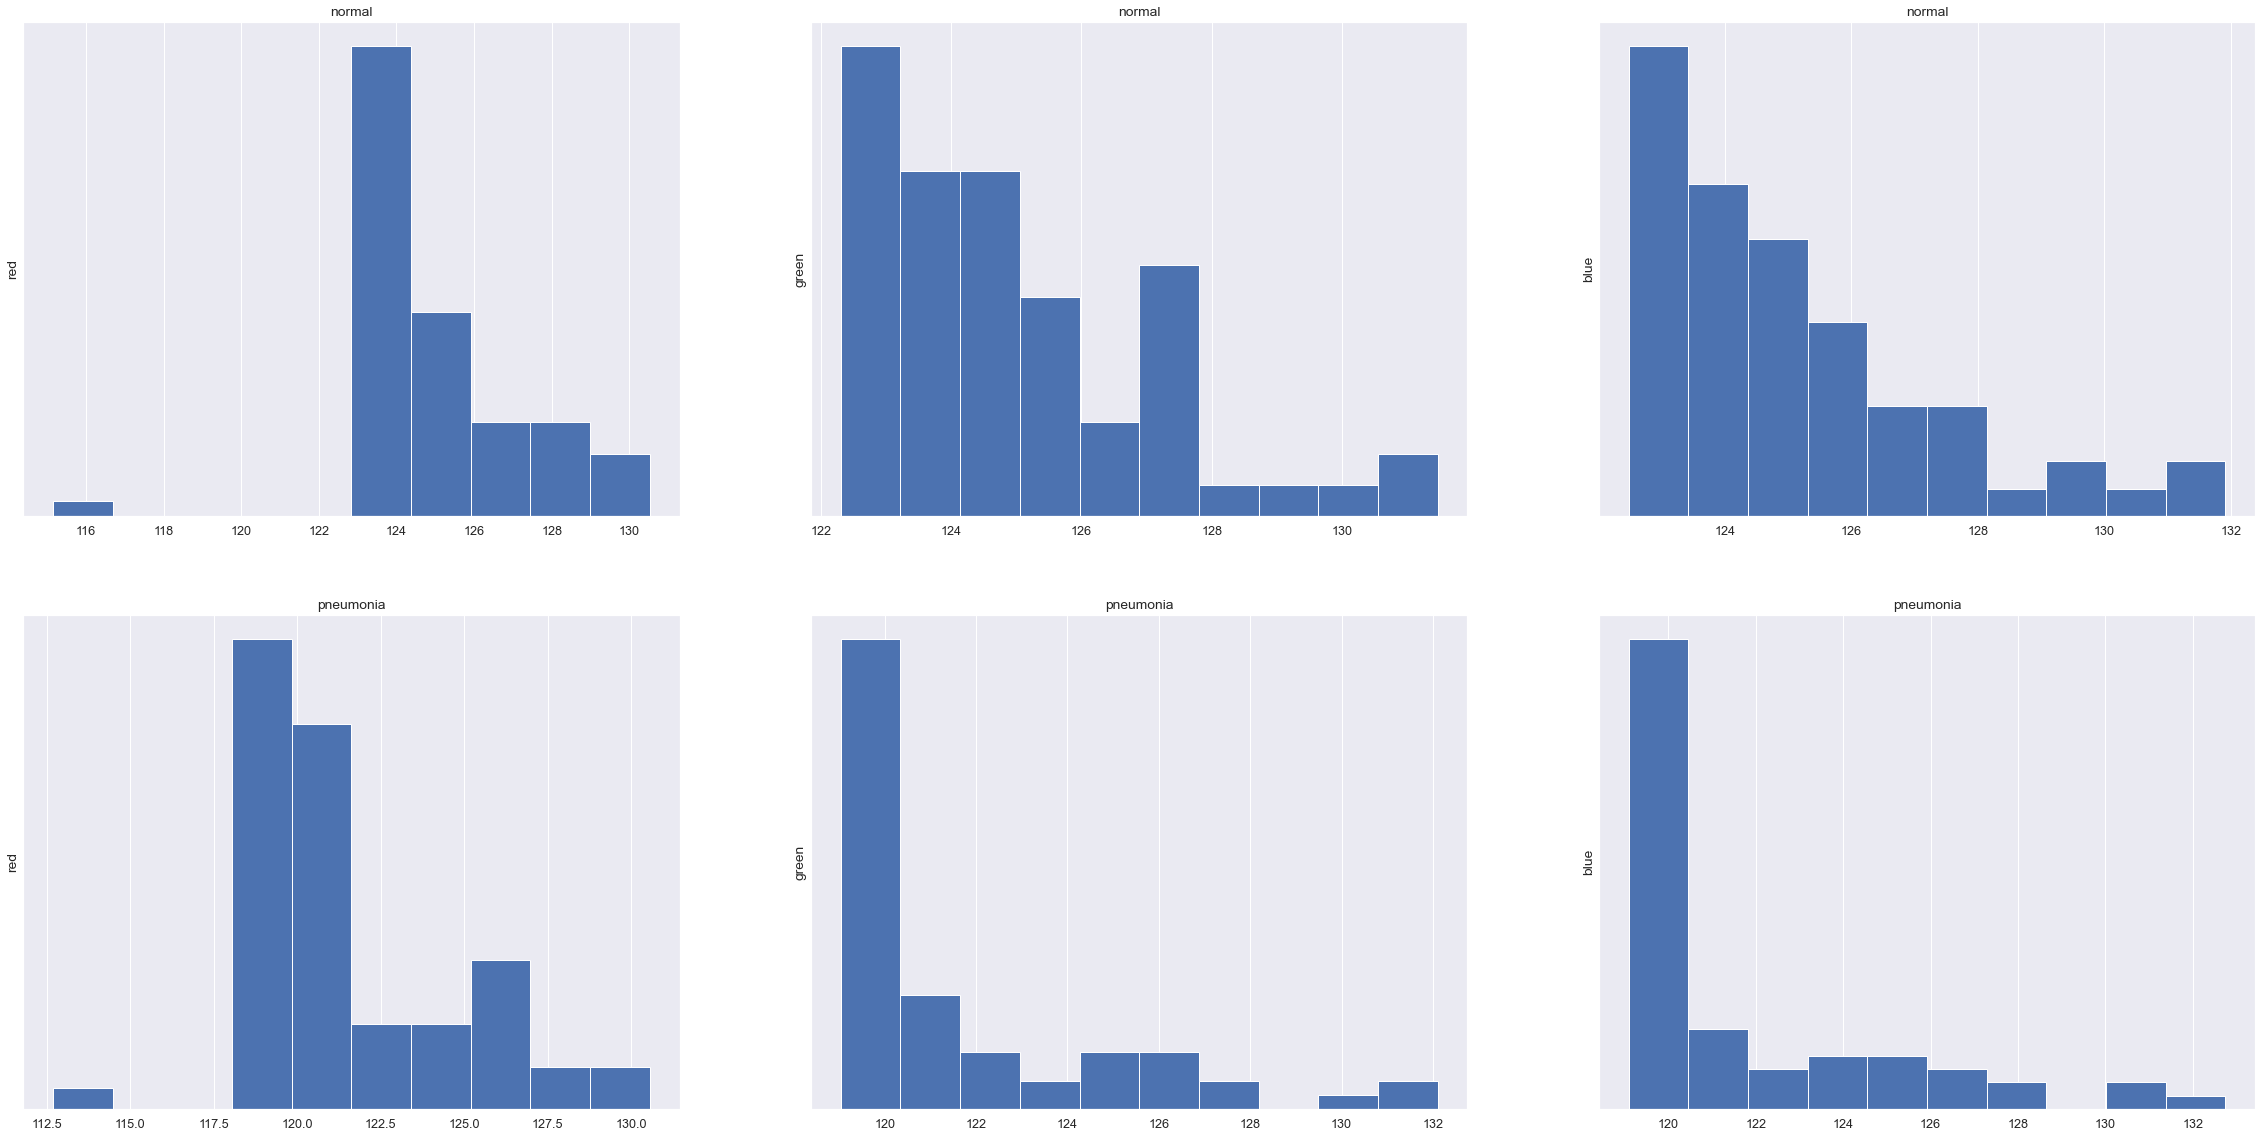

In [42]:
plot_color_RGB_distribution(normal_fft, pneumonia_fft)

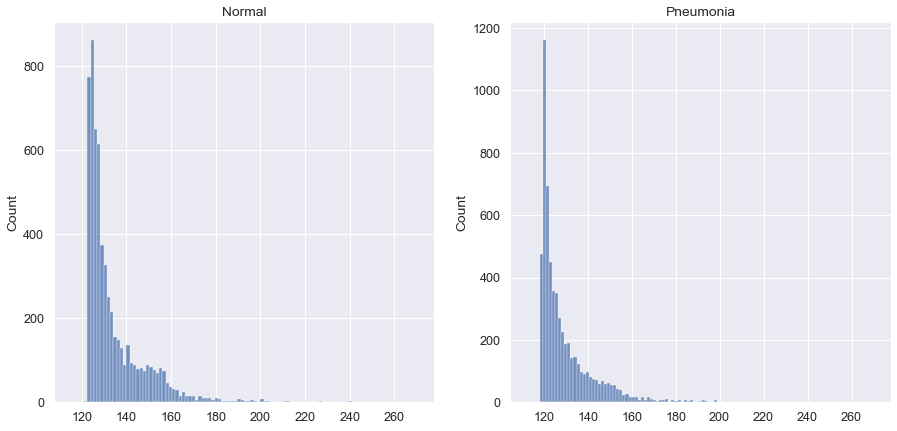

In [43]:
plot_color_distribution(normal_fft, pneumonia_fft)

We can't see any major difference between normal and pneumonia images, but apparently they have some differences, mainly in the distributoni of pixels in the images. Normal images pixels seems to have a wider distribution than the pneumonia images.

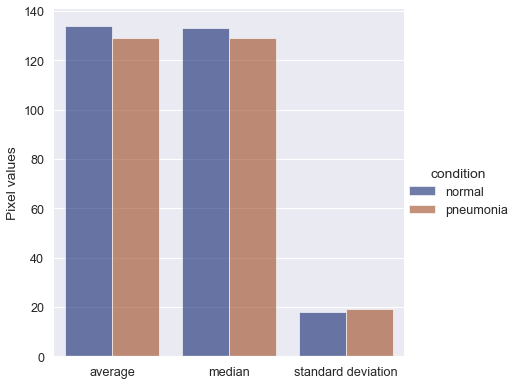

In [236]:
plot_pixel_values(normal_fft, pneumonia_fft)

After all, we hoped to gain more insight by examine different feature extraction methods but it didn't happen for us.<br>Next we will check a different approach of looking at our data, and that is the PCA method

### PCA

We will start by defining our pca model and compiling it on our combined dataset of images of both the pneumonia and normal images: 

In [149]:
normal_flattened = []
pneumonia_flattened = []

for image in normal_data:
    normal_flattened.append(image.flatten())
    
for image in pneumonia_data:
    pneumonia_flattened.append(image. flatten())

combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

PC1        PC2        PC3        PC4        PC5        PC6
0 -11.739896  20.709378  33.057155  -3.488442  10.704765  36.680808
1 -47.465511 -12.719462  17.865605   4.914068 -12.638080  10.979679
2 -22.774161  23.508687  37.292035   9.330551  13.611173  19.670333
3 -35.245922  54.317781  30.141211  14.385814 -13.055888   0.495732
4 -25.918642  27.331506  38.633680  20.172699  14.769082  12.064653

explained variance ratio (first three components): [0.29068861 0.09298998 0.06840393]
sum of first three components: 0.452083


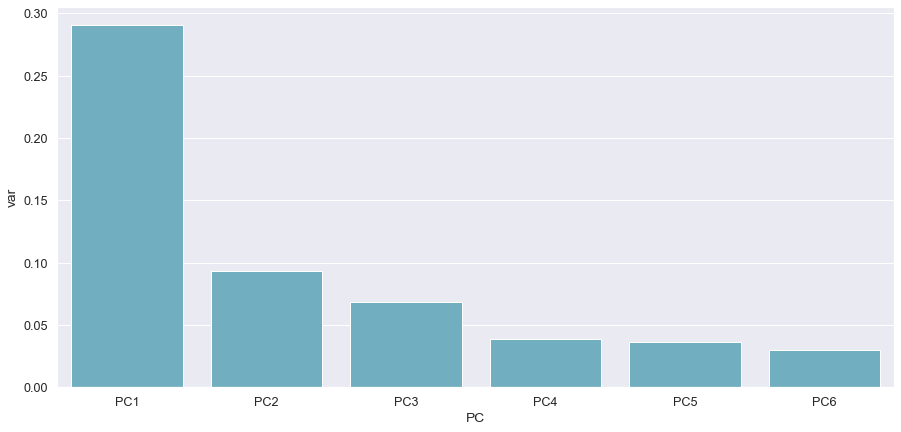

In [150]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

print('explained variance ratio (first three components): %s' % str(pca.explained_variance_ratio_[:3]))
print('sum of first three components: %f' % float(sum(pca.explained_variance_ratio_[:3])))

We can see that the first PC contains about a third of the variance in the images while the first three combined hold almost half of all the variance between the images. Therefore we will only analyze the first 3 PCs. We will now proceed to divide the images based on their PC scores and see if any of them will show a pattern of normal/pneumonia images or have any visible properties which can help to analyze the images. All PCs will be shown with the first 2 rows of images corresponding to the higest score and the second 2 rows will correspond to the low PC score.

Lets define a function to print the images as described above:

In [151]:
def plot_pca_images(pca_num, normal_data, pneumonia_data):
    highest_score_ids = np.argpartition(combined_reduced[:, pca_num], -8)[-8:]
    lowest_score_ids = np.argpartition(combined_reduced[:, pca_num], 8)[:8]

    combined_images = normal_data + pneumonia_data
    labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)
    
    plt.figure(figsize=(15,10))
    for num, ids in enumerate(np.concatenate((highest_score_ids, lowest_score_ids), axis=0)):
        img = combined_images[ids]
        plt.subplot(4,4,num+1)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
        plt.title(f"{labels[ids]}",fontsize=18)

#### First PC

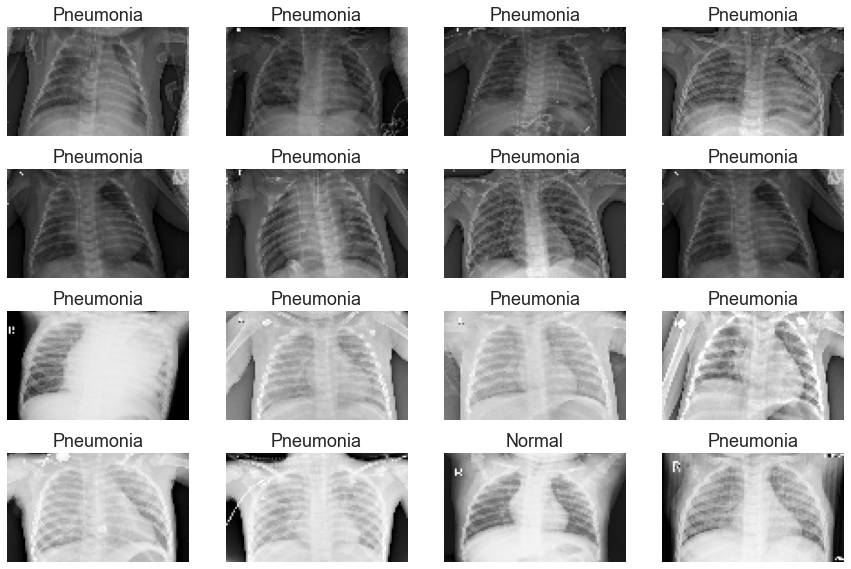

In [152]:
plot_pca_images(0, normal_data, pneumonia_data)

It can be clearly seen that the first PC is that of the total brightness of the images (the mean value of the pixels of the images). It can be noticed that both the first two rows (lowest score) and the last two rows (highest score) are both entirely made of pneumonia images, as such, this PC does not help our classification. However, this is a major PC that be accounted for by normalizing all the images according to their average pixel value. This could potentially help the model classify images.

#### Second PC

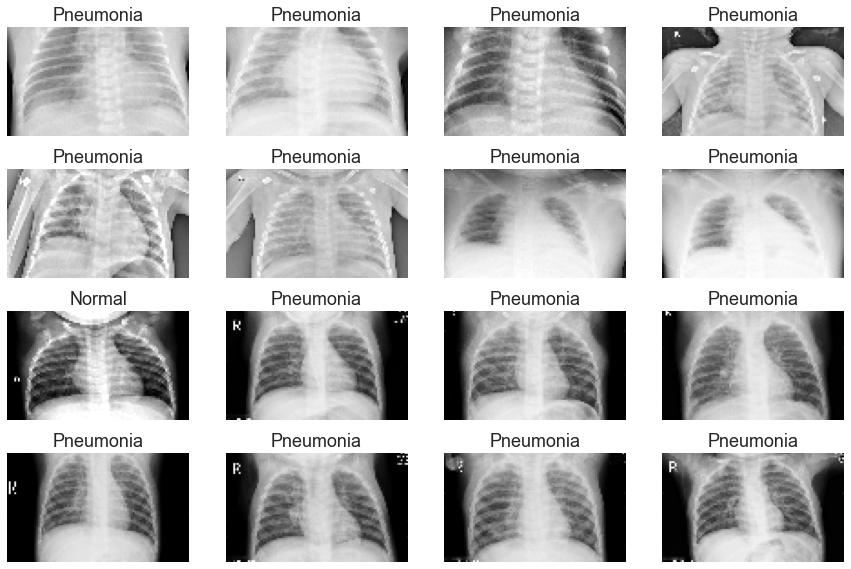

In [153]:
plot_pca_images(1, normal_data, pneumonia_data)

It can be seen that this PC corresponds to the amount of background that exists in the image. Similar to the first PC, this PC doesn't help us very much for classifying as all rows are consisted of entirely pneumonia images. We can normalize with regards to this PC as well, however, in contrast to the first PC, this PC accounts for a much smaller part of the variance and as such the 'return on investment' for normalizing in respect to it will be low.

#### Third PC

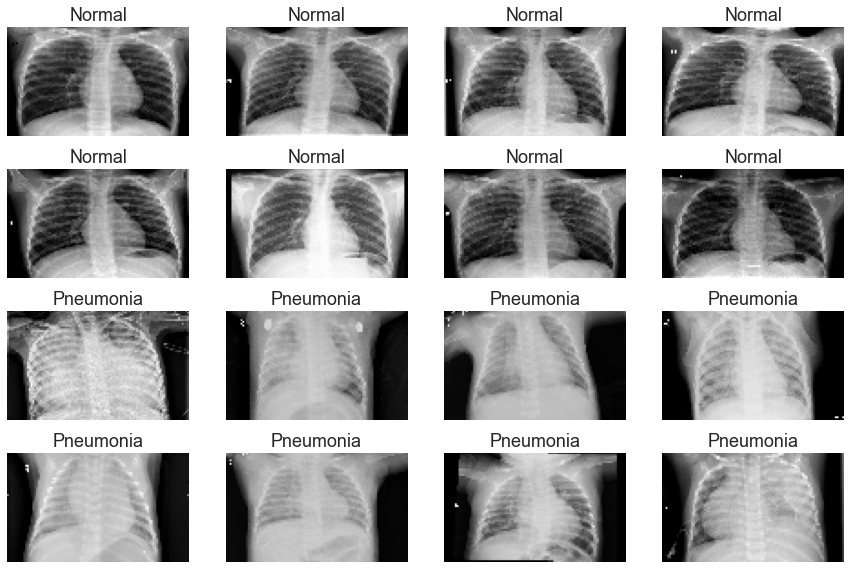

In [154]:
plot_pca_images(2, normal_data, pneumonia_data)

Jackpot! This PC has managed to completly divide between the pneumonia images and the normal images with an accuracy of 100% for 16 images. This has to be taken seriously and such we will check its total accuracy for all the images and attempt to use it as a classfication tool.
# TALK ABOUT WHAT THE PC IS

The way this will be done will be by arranging the data in an array from the highest PC score to the lowest PC score. We will then divide the array to two arrays according to the relative size of the data. Every normal image in the first array will be counted and divided by the length of the array. Thats the accuracy for the normal image prediction. The same will be done for pneumonia images and the second array. The total accuracy will be the weighted average of both accuracies.

##### Testing the pca  

In [155]:
NORMAL_LENGTH = len(normal_data) #1575
PNEUMONIA_LENGTH = len(pneumonia_data) # 4275

labels = ["Normal"]*len(normal_data) + ["Pneumonia"]*len(pneumonia_data)

predicted_as_normal = np.argpartition(combined_reduced[:, 2], NORMAL_LENGTH)[:NORMAL_LENGTH]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 2], -PNEUMONIA_LENGTH)[-PNEUMONIA_LENGTH:]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 65 % pneumonia images
The normal group contains: 5 % normal images
The total accuracy is: 48 % 



The total accuracy of our third PC is quite impressive. We managed to find a classifying tool, without any complex models, that performs with accuracy of 88%. 

#### Normalizing the first PC

In order to account for the first PCA and to reduce the interference of irelevant image properties, we will normalize all the images with respect to their mean pixel value and re-attempt the pca analysis. 

In [156]:
for index, image in enumerate(normal_flattened):
    normal_flattened[index] = image / np.mean(image)

for index, image in enumerate(pneumonia_flattened):
    pneumonia_flattened[index] = image / np.mean(image)
    
combined_pca = sklearn.preprocessing.StandardScaler().fit_transform(normal_flattened + pneumonia_flattened)
pca = sklearn.decomposition.PCA(n_components = 6)
pca.fit(combined_pca)
combined_reduced = pca.transform(combined_pca)
combined_pca_df = pd.DataFrame(data=combined_reduced,columns=['PC1','PC2','PC3','PC4','PC5','PC6'] )
combined_pca_df.head()

PC1        PC2        PC3        PC4        PC5        PC6
0 -34.252956 -22.605889  17.331141   1.065041  -5.070084  45.245662
1 -14.090140 -27.830852 -15.620046  -3.522644  -3.236126   0.810212
2 -40.341136 -23.792983  18.041044  14.760926   6.122588  32.262844
3 -67.440044  -7.342272  14.820162   6.772989  30.479026  22.666522
4 -45.306657 -23.287056  15.237731  23.542272   9.610562  25.429529

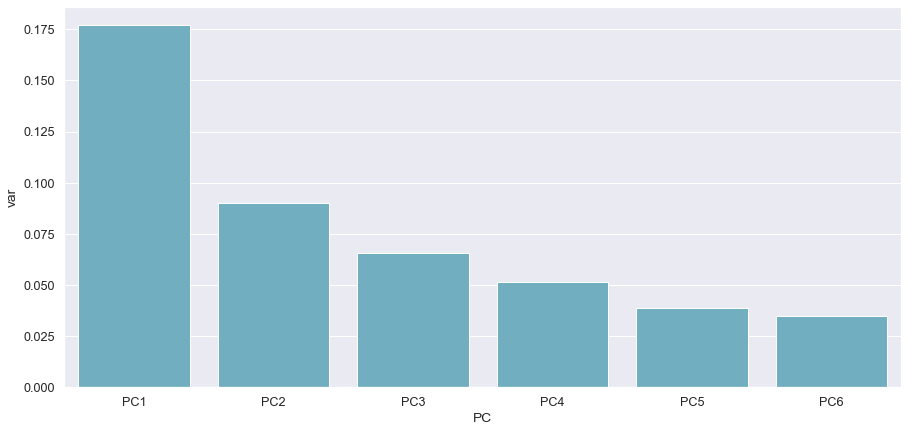

In [157]:
pca.explained_variance_ratio_

df = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':['PC1','PC2','PC3','PC4','PC5','PC6']})
sns.barplot(x='PC',y="var",data=df, color="c");

#### First PC

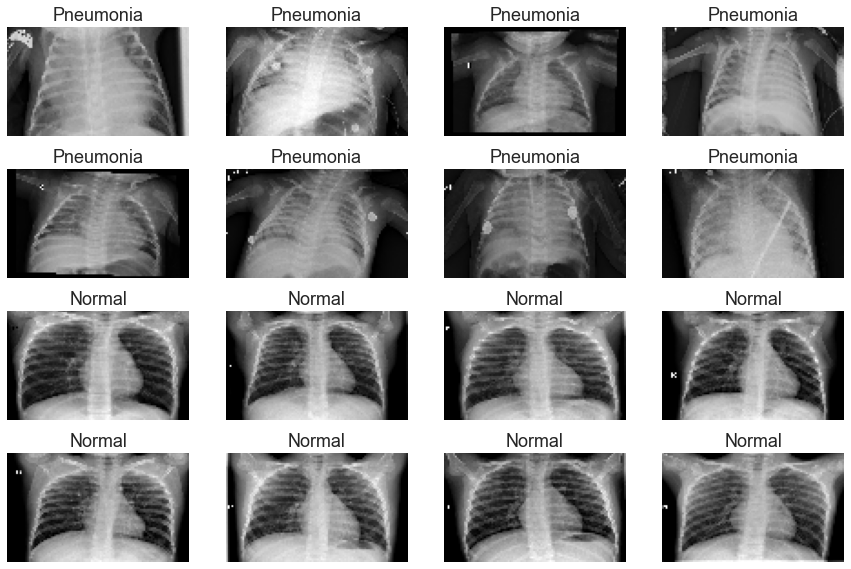

In [158]:
plot_pca_images(1, normal_data, pneumonia_data)

We can see that this represents the second PC of the original PCA analysis.

#### Second PC

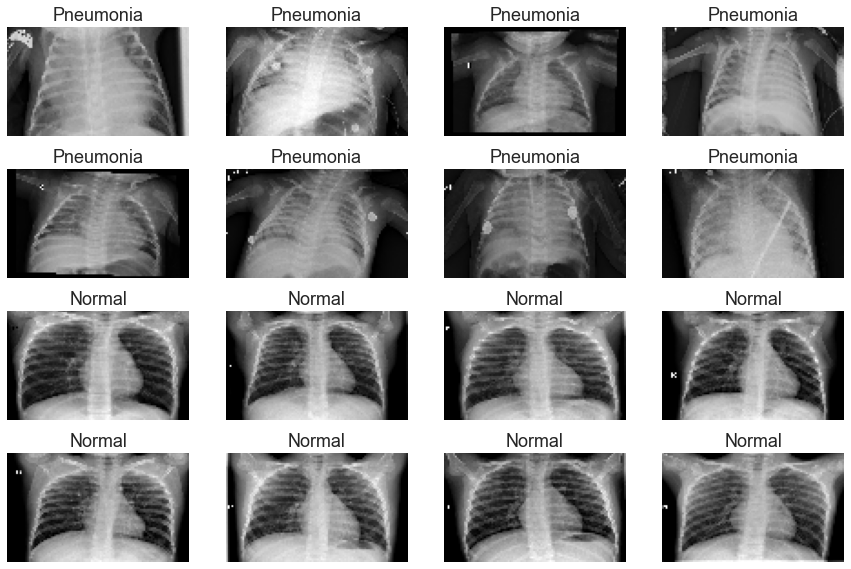

In [159]:
plot_pca_images(1, normal_data, pneumonia_data)

We can see that this represents the third PC from the original PCA analysis.

Lets re-check the third PC's accuracy and see if the accuracy has increased after normalizing with respect to the first PC.

##### Testing the pca  

In [160]:
NORMAL_LENGTH = len(normal_data) #1575
PNEUMONIA_LENGTH = len(pneumonia_data) # 4275

predicted_as_normal = np.argpartition(combined_reduced[:, 1], -NORMAL_LENGTH)[:NORMAL_LENGTH]
predicted_as_pneumonia = np.argpartition(combined_reduced[:, 1], PNEUMONIA_LENGTH)[-PNEUMONIA_LENGTH:]

normal_count = 0
pneumonia_count = 0

for image in predicted_as_pneumonia:
    if labels[image] == "Pneumonia":
        pneumonia_count += 1

for image in predicted_as_normal:
    if labels[image] == "Normal":
        normal_count += 1

pneumonia_group_accuracy = int(100*pneumonia_count/PNEUMONIA_LENGTH)
normal_group_accuracy = int(100*normal_count/NORMAL_LENGTH)
total_accuracy = int((pneumonia_group_accuracy * PNEUMONIA_LENGTH + normal_group_accuracy * NORMAL_LENGTH) / (NORMAL_LENGTH + PNEUMONIA_LENGTH ))

print(f"The pneumonia group contains: {pneumonia_group_accuracy} % pneumonia images")
print(f"The normal group contains: {normal_group_accuracy} % normal images")
print(f"The total accuracy is: {total_accuracy} % \n")


The pneumonia group contains: 98 % pneumonia images
The normal group contains: 94 % normal images
The total accuracy is: 96 % 



Indeed as expected, by normalizing with respect to the first PC we have managed to increase further the accuracy of this classification tool. We have managed to reach a highly impressive 96% accuracy.

##### Visualizing the PCA

Through the analysis mentioned above, we have managed to reduce the problem almost entirely to one dimension. Let us visualize the PCA distrubition on a 2 dimensional graph to see the respective variance. 

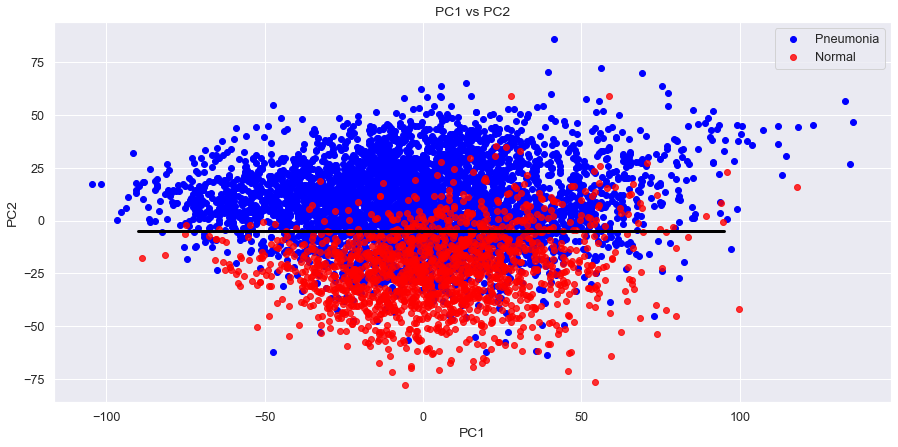

In [162]:
columns = ['PC' + str(i) for i in range(6)]
pca_df = pd.DataFrame(data=combined_reduced , columns=columns)


plt.scatter(pca_df.PC0[1575:], pca_df.PC1[1575:], c='blue')
plt.scatter(pca_df.PC0[:1575], pca_df.PC1[:1575], c='red', alpha=0.8)
plt.legend([ 'Pneumonia', 'Normal'])

plt.axhline(y=-5, xmin=0.1, xmax=0.8, color='black', linewidth=3)


plt.title('PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

As can be clearly seen, PC2 (PC3 before the dimension reduction) splits the data very well between the sick and healthy patients.

# NOT AS ACCURATE AS EXPECTED THOUGH

## Classification models
As seen in the PCA section, we can find simple and easy methods to use functions to predict and classify our data. After seen it happening in the last section, we are hoping we can make other models that are still relatively simple and perform well on the same tasks.

### Data Preperation

Before feeding the data to the models we need to perform various manipulations to conform to the format required by the neural network. The following blocks of code will describe this process.

Firstly, the values of the pixels are normalized from (0,255) to (0,1):

In [19]:
print(type(normal_data[0][0][0]))

<class 'numpy.float64'>


In [18]:
print("Image before normalization: \n" + str(normal_data[0]))

for index, image in enumerate(normal_data):
    normal_data[index] = image / 255
    
for index, image in enumerate(pneumonia_data):
    pneumonia_data[index] = image / 255

print("\n\n Image after normalization: \n" + str(normal_data[0]))

Image before normalization: 
[[31 32 30 ... 34 30 35]
 [30 31 28 ... 32 33 32]
 [30 34 30 ... 29 31 34]
 ...
 [30 28 30 ... 33 35 35]
 [31 29 27 ... 34 33 36]
 [30 27 27 ... 34 34 35]]


 Image after normalization: 
[[0.12156863 0.1254902  0.11764706 ... 0.13333333 0.11764706 0.1372549 ]
 [0.11764706 0.12156863 0.10980392 ... 0.1254902  0.12941176 0.1254902 ]
 [0.11764706 0.13333333 0.11764706 ... 0.11372549 0.12156863 0.13333333]
 ...
 [0.11764706 0.10980392 0.11764706 ... 0.12941176 0.1372549  0.1372549 ]
 [0.12156863 0.11372549 0.10588235 ... 0.13333333 0.12941176 0.14117647]
 [0.11764706 0.10588235 0.10588235 ... 0.13333333 0.13333333 0.1372549 ]]


Following that, we would like to split the data to train, validation and test groups. In order to use our data in multiple and variant models, we would split and adjust it in different ways with the use of NumPy and Sklearn libraries:


In [45]:
# Explantion for the next part:
#
# create 3 arrays: train with validation (first 2 arrays)
#                  test array (different testing array)
#
# TRAIN + VALIDATION = 66%, TEST = 33%
# TRAIN / VALIDAION = (80/20)

##### Prepare 2D data

In [7]:
# create 3 arrays: train with validation (first 2 arrays)
#                  test array (different testing array)

# total normal cases: 1575 -> (train:844, valid:211, test:520)
# total pneumonia cases: 4265 -> (train:2285 , valid:572 , test:1408)
# total cases : train:3129, valid:783, test:1928


# Creating lists of labels
normal_labels = [0]*len(normal_data)
pneumonia_labels = [1]*len(pneumonia_data)



# split the normal and pneumonia data to (TRAIN and VALIDATION : TEST)(66:33)
normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(normal_data, normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(pneumonia_data, pneumonia_labels, test_size=0.33)

# split the normal and pneumonia TRAIN and VALIDATION to (TRAIN : VALIDATION)(80:20)
normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

# concatenate normal and pneumonia data
train_data = normal_train_data + pneumonia_train_data
train_labels = normal_train_labels + pneumonia_train_labels
NN_train_labels = to_categorical(train_labels, num_classes=2) # categorize labels 

valid_data = normal_valid_data + pneumonia_valid_data
valid_labels = normal_valid_labels + pneumonia_valid_labels
NN_valid_labels = to_categorical(valid_labels, num_classes=2) # categorize labels 

test_data = normal_test_data + pneumonia_test_data
test_labels = normal_test_labels + pneumonia_test_labels
NN_test_labels = to_categorical(test_labels, num_classes=2) # categorize labels 

# compress all data to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
NN_train_labels = np.array(NN_train_labels)

valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
NN_valid_labels = np.array(NN_valid_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
NN_test_labels = np.array(NN_test_labels)

In [166]:
# verification of TRAIN, VALIDATION, TEST data
print(train_data.shape)
print(train_labels.shape)
print(NN_train_labels.shape)

print(valid_data.shape)
print(valid_labels.shape)
print(NN_valid_labels.shape)

print(test_data.shape)
print(test_labels.shape)
print(NN_test_labels.shape)

(3129, 60, 100)
(3129,)
(3129, 2)
(783, 60, 100)
(783,)
(783, 2)
(1928, 60, 100)
(1928,)
(1928, 2)


The reason we created two types of labels is that we are about to use different models to classify our data, and different models uses different labels format to train the data.<br>The first group of train/valid/test_labels fits simple Machine Learning models, and the second group Neural Network(NN)_train/valid/test_labels will fit Neural Networks models.

##### Prepare flatten data

In [167]:
# Creatin flatten data
flatten_train_data = np.array([])
flatten_valid_data = np.array([])
flatten_test_data = np.array([])

flatten_train_data = train_data.reshape(train_data.shape[0],-1)

flatten_valid_data = valid_data.reshape(valid_data.shape[0],-1)

flatten_test_data = test_data.reshape(test_data.shape[0],-1)

In [168]:
# verification of flatten TRAIN, VALIDATION, TEST data
print(flatten_train_data.shape)
print(flatten_valid_data.shape)
print(flatten_test_data.shape)

(3129, 6000)
(783, 6000)
(1928, 6000)


Now our data is ready to use. Let's try the first model - Multinomial Naive Bayes 

### Naive Bayes
This algorithm is based on Bayes Theorem. It takes single 1-dimension vector as input and make a prediction based on the values in the vector. In our case we will represent image as vector by flatten all of it's pixel values, so we can use Naive Bayes algorithm to predict whether an image is of type normal or pneumonia.

In [169]:
NB_flatten_train_data = np.asarray(flatten_train_data.tolist() + flatten_valid_data.tolist())
NB_train_labels =  np.asarray(train_labels.tolist() + valid_labels.tolist())

In [170]:
classifier = MultinomialNB()
classifier.fit(NB_flatten_train_data, NB_train_labels)

MultinomialNB()

In [171]:
def plot_NB_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data)

    # Original labels
    orig_test_labels = testing_labels

    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)

    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='PREDICTED', ylabel='ACTUAL', title=title)
    plt.show()
    
    # Calculate the final accuracy of each condition
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

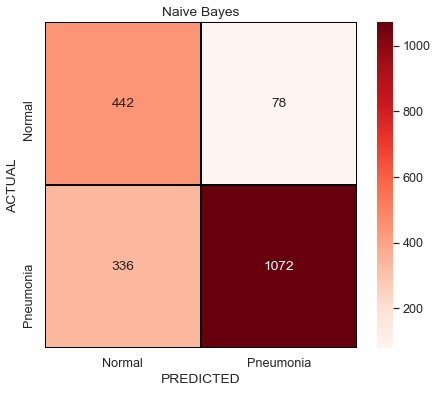

Normal accuracy test score: 85%
Pneumonia accuracy test score: 76%
Total accuracy test score: 78%


In [172]:
plot_NB_confusion_matrix(classifier, flatten_test_data, test_labels, "Naive Bayes")

Our model has a total accuracy score of 78%. This is okay, but after seeing our PCA perform better we figured maybe the "raw" data of an image is not accurate enough for Naive Bayes model to learn.<br>Because of that we decided to try and make a feature extraction model with the assistent of an autoencoder, or more precisly an encoder, and create vector that will represnt each image's main features, and test it again with Naive Bayes model.

## Naive Bayes with Feature Extraction
After testing Naive Bayes model on our images and seeing average results, now we will try to prepare better data and to use it in the same model. Feature Extraction of an image can be made in many ways. We decided to do it with the help of Neural Networks. There is no precise way to do it, but the common ways as of today is to build Neural Networks for image recognition, train it, and extract the data from an intermediate layer of the model. The common belief is that this data will represent the original data as best as possible. 
<br>In this part we will use Neural Networks as Feature Extraction models, hopefully a machine will find meaningful features in the images and we will see better results with the Naive Bayes model.

### Autoencoder as Feature Extractor
Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data.
An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.
The encoder can then be used as a data preparation technique to perform feature extraction on raw data that can be used to train a different machine learning model.

We will train an Autoencoder model to compress an image and reconstructe it back normal, as accurate as possible. Then we will take a vector from an intermediate layer that will represent the data.

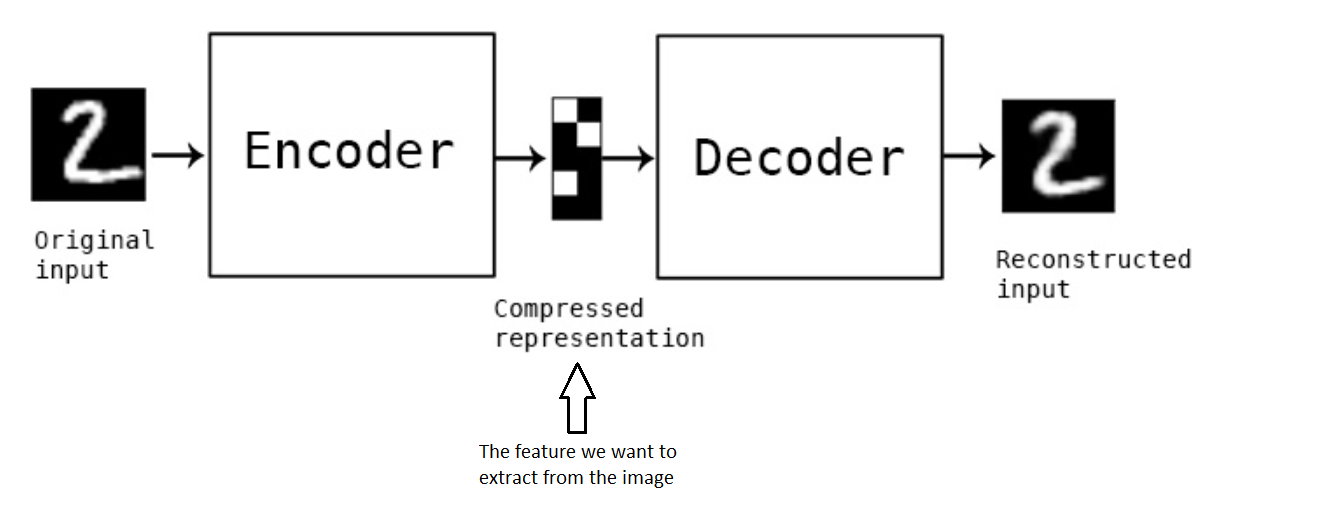

In [173]:
# Functional model
input_img = layers.Input(shape=(60, 100, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

flatten_encoded = layers.Flatten(name='compressed')(encoded)
encoded = layers.Reshape((15, 25, 32))(flatten_encoded)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 100, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 60, 100, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 25, 32)        0         
_________________________________________________________________
compressed (Flatten)         (None, 12000)             0         
_________________________________________________________________
reshape (Reshape)            (None, 15, 25, 32)       

In [183]:
%%time
autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=128,
                shuffle=True,
                verbose=0,
                validation_data=(valid_data, valid_data))

Wall time: 1h 17min 25s


In [188]:
def plot_images_autoencoder(normal_img, pneumonia_img, plot_color):    
    fig, axis = plt.subplots(2,4)
    plt.rcParams["figure.figsize"] = (15,7)

    for index, image in enumerate(normal_img[:4]):
        axis[0,index].imshow(image, cmap=plot_color)
        axis[0,index].set_title('Original image')
    
    for index, image in enumerate(pneumonia_img[:4]):
        axis[1,index].imshow(image, cmap=plot_color)
        axis[1,index].set_title('Reconstructed image')

    plt.show()

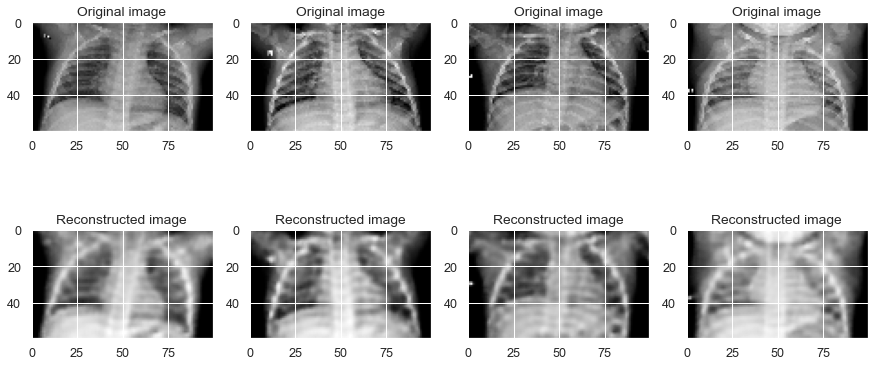

In [189]:
plot_images_autoencoder(test_data, autoencoder.predict(test_data[:4]), "gray")

In order to assess the autoencoder's accuracy we will use a method called cosine similarity that let's us examine the similarity between two(or more) vectors, and in our case an original image to it reconstructed image.

### Cosine similarity 
Cosine similarity is a metric used to measure how similar two or more vectors are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar vectors are far apart by the Euclidean distance (due to the size of the vector), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity.<br>This metric seems to fit our needs when it comes to measure the efficacy of the autoencoder and will allow us to compare the original input to the output image.

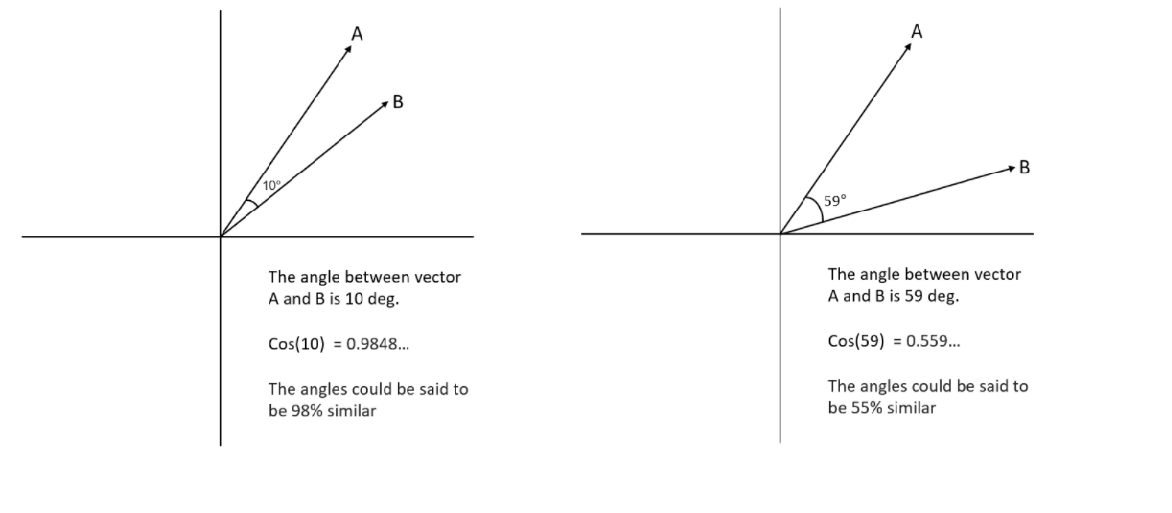

In [186]:
def calc_cosine_similarity(img_A,img_B):
    result = cosine_similarity(img_A.flatten().reshape(1,-1),img_B.flatten().reshape(1,-1))
    result = 100*result[0][0]
    return result

In [190]:
cos_sim = []
predictions = autoencoder.predict(test_data)

for i in range(len(predictions)):
    cos_sim.append(calc_cosine_similarity(predictions[i],test_data[i]))

result = np.mean(cos_sim)
print(("The average similarity between images is: {:.2f}%").format(result))

The average similarity between images is: 99.70%


### Naive Bayes with encoded data

In [191]:
# extract the compressed data from the intermediate layer of the autoencoder
layer_name = 'compressed'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                       outputs=autoencoder.get_layer(layer_name).output)

In [192]:
NB_train_data = np.asarray(train_data.tolist() + valid_data.tolist())

In [193]:
encoder_train = intermediate_layer_model(NB_train_data)
encoder_test = intermediate_layer_model(test_data)

In [194]:
classifier = MultinomialNB()
classifier.fit(encoder_train, NB_train_labels)

MultinomialNB()

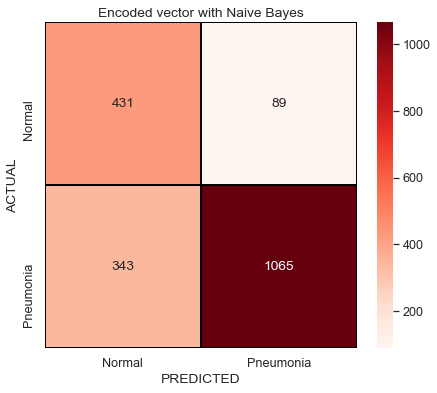

Normal accuracy test score: 82%
Pneumonia accuracy test score: 75%
Total accuracy test score: 77%


In [195]:
plot_simple_confusion_matrix(classifier, encoder_test, test_labels, "Encoded vector with Naive Bayes")

The results are not really satisfying. In fact they are worst then the original images's data.<br> We still have one more idea and this is a pre-traind deep learning image embedding method .

### Img2vec

This is a module that vectorizes images using neural networks. Resnet50 was the first model that is supported, other models were released later. resnet50 is a residual convolutional neural network with 25.5 million parameters trained on more than a million images from the ImageNet database. As the name suggests, it has a total of 50 layers: 48 convolution layers, 1 MaxPool layer and 1 Average Pool layer.

We used git repository for the module Img2vec. What this function does is exactly what it sounds like - Image to  vector embedding. This library uses the ResNet50 model in TensorFlow Keras, pre-trained on Imagenet, to generate image embeddings.<br>This method takes an image as input, and through feature extraction process it creates 1-dimensional vector of 2048 numeric values that represents the main features of the original image.<br>This version of Img2vec is a clone of https://github.com/christiansafka/img2vec for TensorFlow Keras users.   <br>Due to problems we faced while downloading the package, we decided to copy the code directly from https://github.com/jaredwinick/img2vec-keras.



In [174]:
# !pip install git://github.com/jaredwinick/img2vec-keras.git 

from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np


_IMAGE_NET_TARGET_SIZE = (224, 224)


class Img2Vec(object):

    def __init__(self):
        
        model = resnet50.ResNet50(weights='imagenet')
        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, 
                                              outputs=model.get_layer(layer_name).output)

    def get_vec(self, image_path):
        """ Gets a vector embedding from an image.
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        img = image.load_img(image_path, target_size=_IMAGE_NET_TARGET_SIZE)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet50.preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        
        return intermediate_output[0]
    
if __name__ == "main":
     pass  

##### Create Img2vec data
This part looks similar to what we did before, but in order to use images with the function IMG2VEC, the input must be of it's original file format: JPG.<br>
The next block of code will create the same sizes of datasets, but with JPG files instead of images(matrix of pixels)

In [175]:
# Creating lists of labels
vector_normal_labels = [0]*len(normal_data)
vector_pneumonia_labels = [1]*len(pneumonia_data)

#NORMAL_FILES = glob(NORMAL_PATH + "/*.jpeg")
#PNEUMONIA_FILES = glob(PNEUMONIA_PATH + "/*.jpeg")

# split the normal and pneumonia data to (TRAIN and VALIDATION : TEST)(66:33)
normal_train_with_val_data, normal_test_data, normal_train_with_val_labels, normal_test_labels = train_test_split(NORMAL_FILES, vector_normal_labels, test_size=0.33)
pneumonia_train_with_val_data, pneumonia_test_data, pneumonia_train_with_val_labels, pneumonia_test_labels = train_test_split(PNEUMONIA_FILES, vector_pneumonia_labels, test_size=0.33)

# split the normal and pneumonia TRAIN and VALIDATION to (TRAIN : VALIDATION)(80:20)
normal_train_data, normal_valid_data, normal_train_labels, normal_valid_labels = train_test_split(normal_train_with_val_data, normal_train_with_val_labels, test_size=0.2)
pneumonia_train_data, pneumonia_valid_data, pneumonia_train_labels, pneumonia_valid_labels = train_test_split(pneumonia_train_with_val_data, pneumonia_train_with_val_labels, test_size=0.2)

# concatenate normal and pneumonia data
raw_train_data = normal_train_data + pneumonia_train_data
raw_valid_data = normal_valid_data + pneumonia_valid_data
raw_test_data = normal_test_data + pneumonia_test_data

# compress all data to numpy arrays
raw_train_data = np.array(raw_train_data)
raw_valid_data = np.array(raw_valid_data)
raw_test_data = np.array(raw_test_data)

In [176]:
# verification of TRAIN, VALIDATION, TEST img2vec data
print(raw_train_data.shape)
print(raw_valid_data.shape)
print(raw_test_data.shape)

(3129,)
(783,)
(1928,)


#### Create vectors of our images

In [177]:
%%time
img2vec_train_data = []
img2vec_valid_data = []
img2vec_test_data = []

# intiate vectors
#for img in tqdm(raw_train_data):
#    img2vec_train_data.append(img2vec.get_vec(img))
    
#for img in tqdm(raw_valid_data):
#    img2vec_valid_data.append(img2vec.get_vec(img))
  
#for img in tqdm(raw_test_data):
#    img2vec_test_data.append(img2vec.get_vec(img)) 

Wall time: 8.01 ms


In [178]:
# compress all data to numpy arrays
img2vec_train_data = np.array(img2vec_train_data)
img2vec_valid_data = np.array(img2vecr_valid_data)
img2vec_test_data = np.array(img2vec_test_data)

print(img2vec_train_data.shape)
print(img2vec_valid_data.shape)
print(img2vec_test_data.shape)

NameError: name 'img2vecr_valid_data' is not defined

In [179]:
# This last 2 blocks took about 6 hours, so the first thing to do was to save the results for future use.
# This is how to save and load them(when you have the files stored on the computer in the SAME DIRECTORY:

# SAVE IMG2VEC DATA
# np.save('img2vec_train_data.npy', img2vec_train_data)
# np.save('img2vec_valid_data.npy', img2vec_valid_data)
# np.save('img2vec_test_data.npy', img2vec_test_data)
#
# LOAD IMG2VEC DATA
img2vec_train_data = np.load('img2vec_train_data.npy')
img2vec_valid_data = np.load('img2vec_valid_data.npy')
img2vec_test_data = np.load('img2vec_test_data.npy')

###  Naive Bayes with Img2vec 

In [180]:
NB_img2vec_train_data = np.asarray(img2vec_train_data.tolist() + img2vec_valid_data.tolist())

In [181]:
classifier = MultinomialNB()
classifier.fit(NB_img2vec_train_data, NB_train_labels)

MultinomialNB()

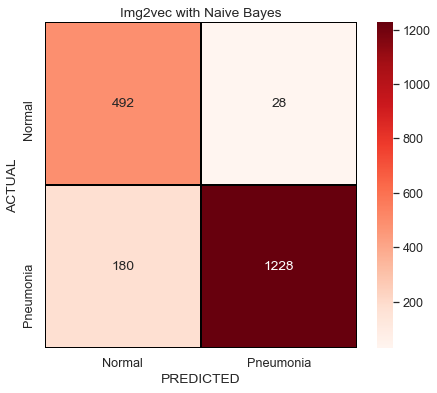

Normal accuracy test score: 94%
Pneumonia accuracy test score: 87%
Total accuracy test score: 89%


In [182]:
plot_simple_confusion_matrix(classifier, img2vec_test_data, test_labels, "Img2vec with Naive Bayes")

Wow! our img2vec method perform great and by using the embedded vectors in Naive Bayes we recieved classification accuaracy of 89%!

### Conclusion Thus Far
We tested 3 types of data with Naive Bayes classifier to predict images as normal or pneumonia. 
- Original images as 1-dimensional vector.
- Features Extraction data from a train Autoencoder.
- Deep learning image embeddings using pre-trained ResNet50 - Img2vec.

In [35]:
## TODO Table to show the results thus far.

## Basic neural network

After finishing testing our data with Naive Bayes models it is finally time to create a Neural Network model and train it on the data. The first step will be to build a relatively simple neural network, that will recieve a 1-dimensional vector representing each image.

In [204]:
def basic_neural_network(input_shape):
    model = Sequential()

    model.add(Dense(512, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.summary()
    return model

In [205]:
model = basic_neural_network((100*60,))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               3072512   
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)               

Now that we have a Neural Network model, let's train it, but first we will add plotting functions, early stop parameters and learning decay, in order to improve out model's learning process and to save resources when the learning process is not improving any more:

In [8]:
def plot_results(test_model, testing_data, testing_labels):
    score = test_model.evaluate(testing_data, testing_labels, verbose=1)
    print("\nThe final results are:\n")
    print(f'Test loss: {int(100*score[0])}%')
    print(f'Test accuracy: {int(100*score[1])}%')

    
    
def plot_history(model_fit):
    plt.rcParams["figure.figsize"] = (15,8)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_fit.history[metric])
        ax[i].plot(model_fit.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

        
        
def plot_NN_confusion_matrix(test_model, testing_data, testing_labels, title):
    # Get predictions
    prediction = test_model.predict(testing_data, batch_size=16)
    prediction = np.argmax(prediction, axis=-1)
    
    # Original labels
    orig_test_labels = np.argmax(testing_labels, axis=-1)
    
    # Get the confusion matrix
    cm  = confusion_matrix(orig_test_labels, prediction)
    
    cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
    plt.rcParams["figure.figsize"] = (7,6)
    sns.heatmap(cm,cmap= "Reds", linecolor = 'black' ,
                linewidth = 1 , annot = True, fmt='',
                xticklabels = ['Normal', 'Pneumonia'],
                yticklabels = ['Normal', 'Pneumonia']).set(xlabel='Predicted', ylabel='Actual', title=title)
    plt.show()
    
    tn, fp, fn, tp = cm.values.ravel()
    print(f"Normal accuracy test score: {int(100*(tn/(tn+fp)))}%" )        
    print(f"Pneumonia accuracy test score: {int(100*(tp/(tp+fn)))}%" )
    print(f"Total accuracy test score: {int(100*((tn+tp)/(tn+fp+tp+fn)))}%")

In [18]:
LR_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                           factor=.5,
                           patience=10,
                           min_lr=.000001,
                           verbose=1)

ES_monitor = EarlyStopping(monitor='val_loss', patience=20)

### Imbalance dataset solution
Due to the imbalance dataset we have, a solution we propose is to create class weights for the models we are about to train and by that make the learning process accurate as much as possible without any biases that might occur with imbalance dataset.

In [33]:
weights = class_weight.compute_class_weight('balanced',
                                                 [0, 1],
                                                 train_labels)
weights_dict = dict(enumerate(weights))

The model now will get compiled and fit to the data:

In [223]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN = model.fit(flatten_train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(flatten_valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/100
25/25 [==============================] - 6s 223ms/step - loss: 0.8102 - accuracy: 0.5069 - val_loss: 0.6589 - val_accuracy: 0.7305
Epoch 2/100
25/25 [==============================] - 5s 182ms/step - loss: 0.7287 - accuracy: 0.4973 - val_loss: 0.6859 - val_accuracy: 0.7305
Epoch 3/100
25/25 [==============================] - 5s 219ms/step - loss: 0.7043 - accuracy: 0.5235 - val_loss: 0.6858 - val_accuracy: 0.7305
Epoch 4/100
25/25 [==============================] - 5s 191ms/step - loss: 0.6914 - accuracy: 0.5628 - val_loss: 0.6898 - val_accuracy: 0.7037
Epoch 5/100
25/25 [==============================] - 4s 163ms/step - loss: 0.6849 - accuracy: 0.6008 - val_loss: 0.6445 - val_accuracy: 0.8570
Epoch 6/100
25/25 [==============================] - 5s 187ms/step - loss: 0.6672 - accuracy: 0.5996 - val_loss: 0.6496 - val_accuracy: 0.6577
Epoch 7/100
25/25 [==============================] - 4s 180ms/step - loss: 0.5423 - accuracy: 0.7236 - val_loss: 0.4284 - val_accuracy: 0.8314

Epoch 58/100
25/25 [==============================] - 4s 156ms/step - loss: 0.1729 - accuracy: 0.9358 - val_loss: 0.1616 - val_accuracy: 0.9489
Epoch 59/100
25/25 [==============================] - 4s 146ms/step - loss: 0.1854 - accuracy: 0.9351 - val_loss: 0.1541 - val_accuracy: 0.9464
Epoch 60/100
25/25 [==============================] - 4s 155ms/step - loss: 0.1737 - accuracy: 0.9393 - val_loss: 0.1925 - val_accuracy: 0.9336
Epoch 61/100
25/25 [==============================] - 4s 164ms/step - loss: 0.1625 - accuracy: 0.9383 - val_loss: 0.1567 - val_accuracy: 0.9438
Epoch 62/100
25/25 [==============================] - 4s 163ms/step - loss: 0.1663 - accuracy: 0.9332 - val_loss: 0.1840 - val_accuracy: 0.9310
Epoch 63/100
25/25 [==============================] - 4s 156ms/step - loss: 0.1601 - accuracy: 0.9345 - val_loss: 0.1759 - val_accuracy: 0.9413
Epoch 64/100
25/25 [==============================] - 4s 144ms/step - loss: 0.1535 - accuracy: 0.9399 - val_loss: 0.2029 - val_accuracy:

In [224]:
plot_results(model, flatten_test_data, NN_test_labels)

61/61 [==============================] - 0s 7ms/step - loss: 0.1848 - accuracy: 0.9321

The final results are:

Test loss: 18%
Test accuracy: 93%


This results are great. It looks like our simplest model classifies normal and pneumonia images with an accuracy of 93%. But in order to understand the results better, let's plot them first in as graph and confusion matrix:

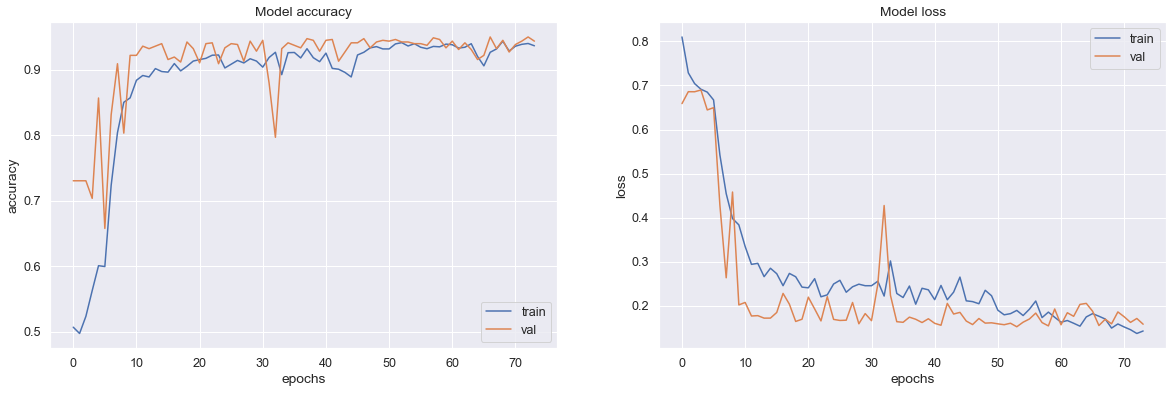

In [225]:
plot_history(basic_NN)

This brings some concerns about the model overfitting  the data. Let's check a differenet approach to examine it

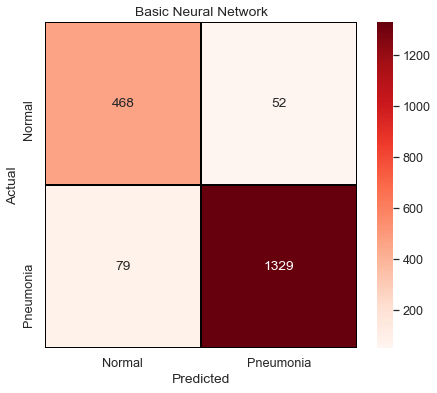

Normal accuracy test score: 90%
Pneumonia accuracy test score: 94%
Total accuracy test score: 93%


In [227]:
plot_NN_confusion_matrix(model, flatten_test_data, NN_test_labels, "Basic Neural Network")

So the model actually perform with accuaracy of 93% and by the confusion matrix we can see his efficiency, eventhough in the graph we suspect the model is overfitting, it is shown that the model really gets the right answers on the test data.(the graph check the train vs validation data where the confusion matrix checks unrelated data that the model didn't met before, which is the test data)

### Basic neural network with img2vec
After seeing the results of the img2vec model with the Naive Bayes we will now test it againg, but with an actual Neural Network.

In [228]:
model = basic_neural_network((2048,))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_42 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)               

In [229]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

basic_NN_with_img2vec = model.fit(img2vec_train_data, NN_train_labels,
                        batch_size=128,
                        epochs=100,
                        verbose=1,
                        shuffle=True,
                        validation_data=(img2vec_valid_data, NN_valid_labels),
                        class_weight=weights_dict,
                        callbacks = [LR_reduce, ES_monitor])

Epoch 1/100
25/25 [==============================] - 5s 214ms/step - loss: 0.6643 - accuracy: 0.6705 - val_loss: 0.3256 - val_accuracy: 0.8506
Epoch 2/100
25/25 [==============================] - 3s 138ms/step - loss: 0.3937 - accuracy: 0.8389 - val_loss: 0.2621 - val_accuracy: 0.8672
Epoch 3/100
25/25 [==============================] - 4s 159ms/step - loss: 0.2948 - accuracy: 0.8750 - val_loss: 0.1667 - val_accuracy: 0.9259
Epoch 4/100
25/25 [==============================] - 4s 156ms/step - loss: 0.2479 - accuracy: 0.8993 - val_loss: 0.1267 - val_accuracy: 0.9591
Epoch 5/100
25/25 [==============================] - 4s 145ms/step - loss: 0.2408 - accuracy: 0.9086 - val_loss: 0.1238 - val_accuracy: 0.9617
Epoch 6/100
25/25 [==============================] - 4s 153ms/step - loss: 0.2005 - accuracy: 0.9220 - val_loss: 0.1290 - val_accuracy: 0.9502
Epoch 7/100
25/25 [==============================] - 4s 171ms/step - loss: 0.1974 - accuracy: 0.9243 - val_loss: 0.1314 - val_accuracy: 0.9489

In [230]:
plot_results(model, img2vec_test_data, NN_test_labels)

61/61 [==============================] - 0s 6ms/step - loss: 0.1545 - accuracy: 0.9512

The final results are:

Test loss: 15%
Test accuracy: 95%


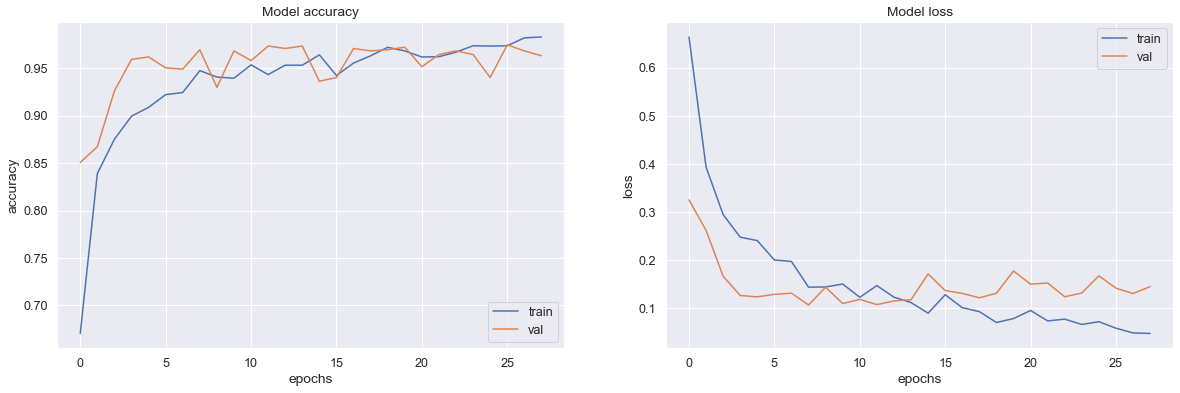

In [231]:
plot_history(basic_NN_with_img2vec)

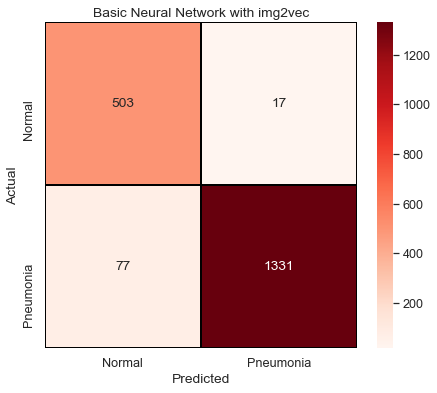

Normal accuracy test score: 96%
Pneumonia accuracy test score: 94%
Total accuracy test score: 95%


In [232]:
plot_NN_confusion_matrix(model, img2vec_test_data, NN_test_labels, "Basic Neural Network with img2vec")

AWESOME!!!!!

### Convolutional Neural Network
Let's test our images in their original format which is a 2D images. 

#### Prepare data

In [11]:
# reshape the data to fit in to our CNN model
train_data = train_data.reshape(train_data.shape[0], 60, 100, 1)
valid_data = valid_data.reshape(valid_data.shape[0], 60, 100, 1)
test_data = test_data.reshape(test_data.shape[0], 60, 100, 1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(3129, 60, 100, 1)
(783, 60, 100, 1)
(1928, 60, 100, 1)


### first attempt

In [234]:
CNN_model = Sequential()

CNN_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_model.add(Flatten())

CNN_model.add(Dense(256, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(128, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(64, activation="relu"))
CNN_model.add(Dropout(0.25))

CNN_model.add(Dense(2, activation='softmax'))

CNN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 100, 32)       544       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 25, 128)       32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 12, 128)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10752)            

Now we can compile the model with 'adam' optimizer and a binary cross entropy loss function that fits  the kind of classification we are dealing with.

In [235]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [236]:
history = CNN_model.fit(train_data, NN_train_labels,
                    batch_size=128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/100
25/25 [==============================] - 27s 1s/step - loss: 0.6123 - accuracy: 0.6226 - val_loss: 0.7492 - val_accuracy: 0.6450
Epoch 2/100
25/25 [==============================] - 26s 1s/step - loss: 0.2967 - accuracy: 0.8821 - val_loss: 0.2775 - val_accuracy: 0.8787
Epoch 3/100
25/25 [==============================] - 26s 1s/step - loss: 0.2085 - accuracy: 0.9163 - val_loss: 0.1506 - val_accuracy: 0.9400
Epoch 4/100
25/25 [==============================] - 25s 1s/step - loss: 0.1589 - accuracy: 0.9441 - val_loss: 0.1718 - val_accuracy: 0.9298
Epoch 5/100
25/25 [==============================] - 25s 983ms/step - loss: 0.1374 - accuracy: 0.9489 - val_loss: 0.1541 - val_accuracy: 0.9438
Epoch 6/100
25/25 [==============================] - 24s 965ms/step - loss: 0.1337 - accuracy: 0.9530 - val_loss: 0.1321 - val_accuracy: 0.9489
Epoch 7/100
25/25 [==============================] - 25s 990ms/step - loss: 0.1137 - accuracy: 0.9613 - val_loss: 0.1628 - val_accuracy: 0.9336
Epoc

### Results

In [237]:
plot_results(CNN_model, test_data, NN_test_labels)

61/61 [==============================] - 4s 62ms/step - loss: 0.2305 - accuracy: 0.9549

The final results are:

Test loss: 23%
Test accuracy: 95%


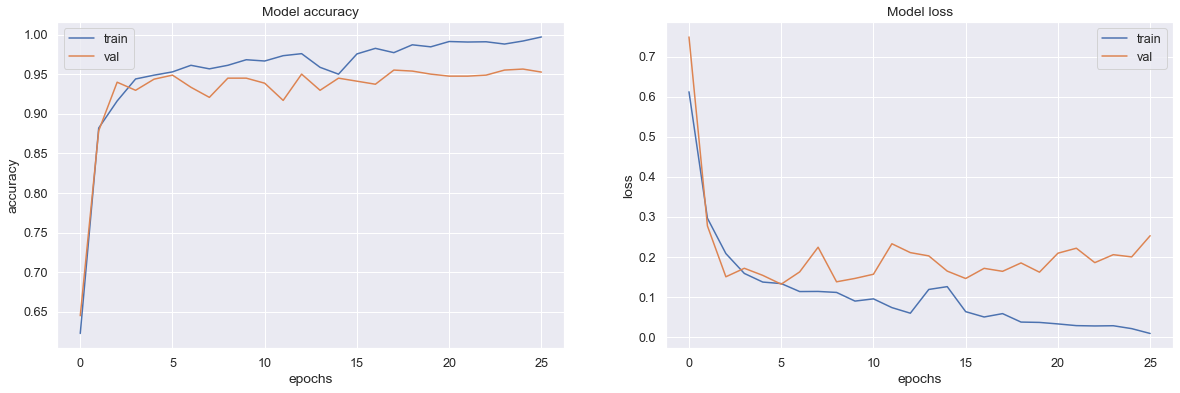

In [238]:
plot_history(history)

Seems like our model is overfitting the data. Eventhough the accuracy of the model is great with 95% efficacy.<br>Let's plot a confusion matrix to check the results

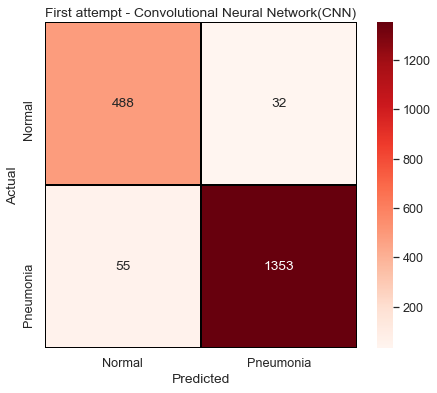

Normal accuracy test score: 93%
Pneumonia accuracy test score: 96%
Total accuracy test score: 95%


In [239]:
plot_NN_confusion_matrix(CNN_model, test_data, NN_test_labels, "First attempt - Convolutional Neural Network(CNN)")

### Second attempt

Let's try to double the conv layers, especially at the early process of the model, hopefully it will add some value to the learning abbilities of the model.

In [240]:
CNN_condense_model = Sequential()

CNN_condense_model.add(Conv2D(32, kernel_size = 2, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_condense_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(3, 3)))

CNN_condense_model.add(Conv2D(128, kernel_size = 4, activation="relu", padding='same'))
CNN_condense_model.add(Conv2D(256, kernel_size = 5, activation="relu", padding='same'))
CNN_condense_model.add(MaxPooling2D(pool_size=(4, 4)))

CNN_condense_model.add(Flatten())

CNN_condense_model.add(Dense(256, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(128, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(64, activation="relu"))
CNN_condense_model.add(Dropout(0.25))

CNN_condense_model.add(Dense(2, activation='softmax'))

CNN_condense_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 60, 100, 32)       160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 100, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 50, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 16, 128)      

In [241]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [242]:
history = CNN_condense_model.fit(train_data, NN_train_labels,
                    batch_size = 128,
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/100
25/25 [==============================] - 152s 6s/step - loss: 0.6969 - accuracy: 0.4813 - val_loss: 0.7042 - val_accuracy: 0.2695
Epoch 2/100
25/25 [==============================] - 153s 6s/step - loss: 0.6535 - accuracy: 0.5248 - val_loss: 0.5802 - val_accuracy: 0.8135
Epoch 3/100
25/25 [==============================] - 153s 6s/step - loss: 0.3836 - accuracy: 0.8575 - val_loss: 0.2575 - val_accuracy: 0.8966
Epoch 4/100
25/25 [==============================] - 143s 6s/step - loss: 0.2076 - accuracy: 0.9227 - val_loss: 0.1903 - val_accuracy: 0.9323
Epoch 5/100
25/25 [==============================] - 141s 6s/step - loss: 0.2084 - accuracy: 0.9163 - val_loss: 0.1834 - val_accuracy: 0.9234
Epoch 6/100
25/25 [==============================] - 142s 6s/step - loss: 0.1650 - accuracy: 0.9351 - val_loss: 0.1609 - val_accuracy: 0.9438
Epoch 7/100
25/25 [==============================] - 140s 6s/step - loss: 0.1699 - accuracy: 0.9386 - val_loss: 0.1411 - val_accuracy: 0.9489
Epoch 

### Results

In [243]:
plot_results(CNN_condense_model, test_data, NN_test_labels)

61/61 [==============================] - 19s 318ms/step - loss: 0.2840 - accuracy: 0.9487

The final results are:

Test loss: 28%
Test accuracy: 94%


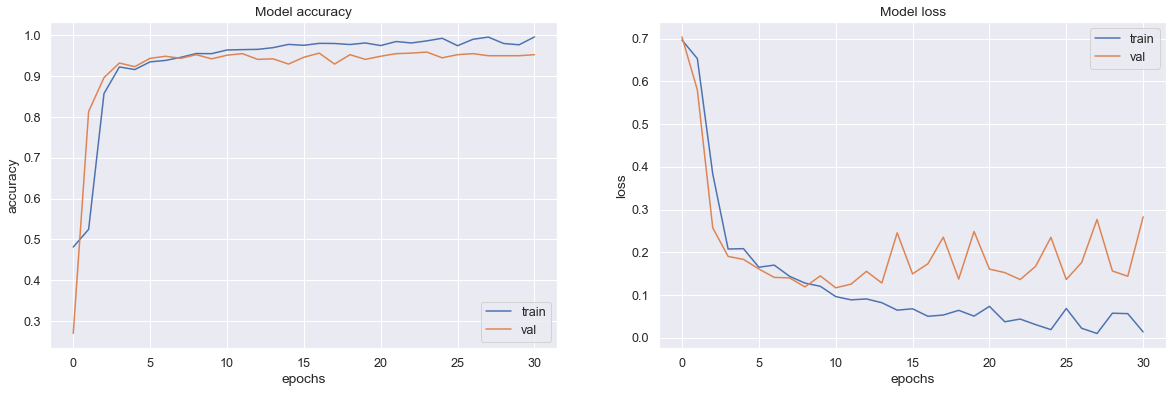

In [244]:
plot_history(history)

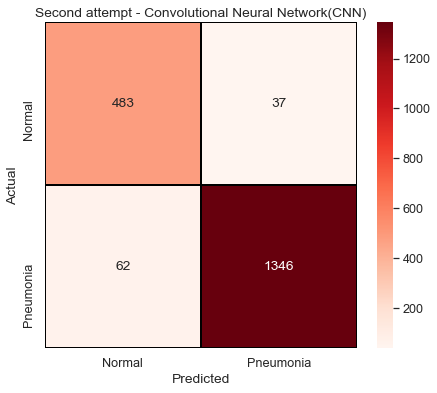

Normal accuracy test score: 92%
Pneumonia accuracy test score: 95%
Total accuracy test score: 94%


In [245]:
plot_NN_confusion_matrix(CNN_condense_model, test_data, NN_test_labels, "Second attempt - Convolutional Neural Network(CNN)")

The results are still great but didn't improve compare to the first attempt nor to the basic neural networks. It's time to pick a different approach.

## SHAP Values
SHAP — which stands for SHapley Additive exPlanations — is probably the state of the art in Machine Learning explainability. This algorithm was first published in 2017 by Lundberg and Lee (https://arxiv.org/abs/1705.07874) and it is a brilliant way to reverse-engineer the output of any predictive algorithm.
SHAP values are used whenever you have a complex model (could be a gradient boosting, a neural network, or anything that takes some features as input and produces some predictions as output) and you want to understand what decisions the model is making.
SHAP values are based on Shapley values, a concept coming from game theory. In a nutshell, the Shapley value is a solution concept in cooperative game theory which describe the impact of each player in the game on acheiving the common goal, and by that can define how much each player "contribute" in acheiving the goal.
When used in Machine Learning, the "game" stands for observation by a model, and the "players" are the features tested by the model. This gives us the option to look behind the scene of the decition making of the Neural Network model and look which feature impact the most on a given prediction.
A CNN model predict WHAT is every image, and the SHAP values tells us WHY.

In this part we will take the wrong prediction of the CNN models and try to understand where the models fall short. We used Softmax Activation function as our output layer. It is used to normalize the output of the network to a probability distribution over predicted output classes, which in our case we have only 2: Normal or Pneumonia. We will use the values of the last layer to find the wrong predictions of our model and examine thier SHAP values.
This code was taken from https://github.com/slundberg/shap.

#### Functions to test WRONG predictions

In [246]:
NUM_OF_TOP_MISTAKES = 10

# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_mistakes_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    errors = (Y_pred_classes - Y_true != 0)

    wrong_pred_labels = Y_pred_classes[errors]
    wrong_pred_distribution = pred[errors]
    true_labels = Y_true[errors]
    wrong_images = testing_data[errors]


    Y_pred_errors_prob = np.max(wrong_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(wrong_pred_distribution, true_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, wrong_images, wrong_pred_labels, true_labels, wrong_pred_distribution


# plot the wrong predictions
def plot_mistakes(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.rcParams["figure.figsize"] = (15,8)
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_values(model, testing_data, wrong_pred, wrong_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in wrong_pred_index[:3]:     #Check out the 5 data that the model has mistakenly predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(wrong_pred[[i]])
    
        if wrong_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if true_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, wrong_pred[[i]] ,index_names ,show=False)
#        plt.figure(figsize=(15,8))
        plt.show()

### First attempt

#### Testing SHAP values of wrong predictions by our model

In [247]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_model, test_data, NN_test_labels)

Let's plot first the 10 top mistakes to see it in our own eyes

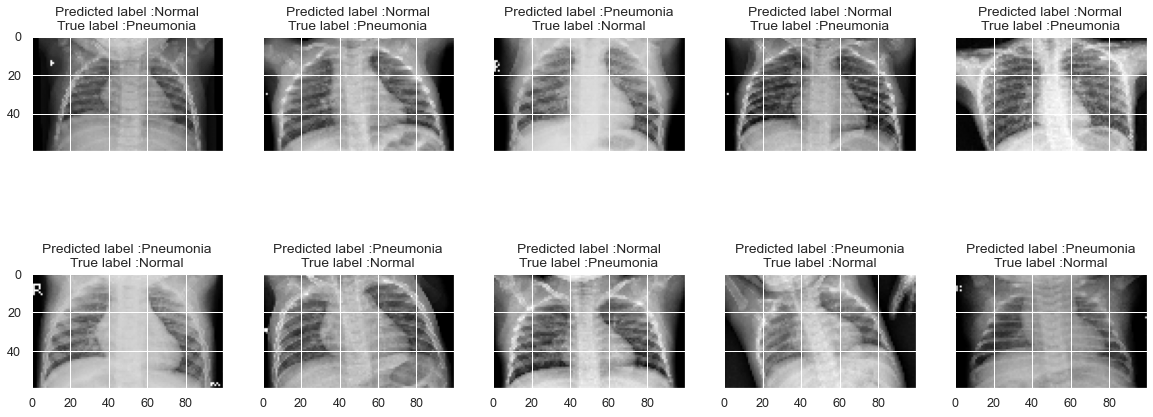

In [248]:
plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

Now it's time to let the SHAP method do his magic:

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Predicted label :Normal
True label :Pneumonia


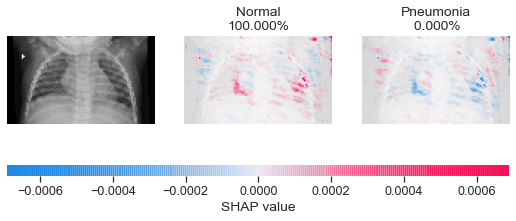

Predicted label :Normal
True label :Pneumonia


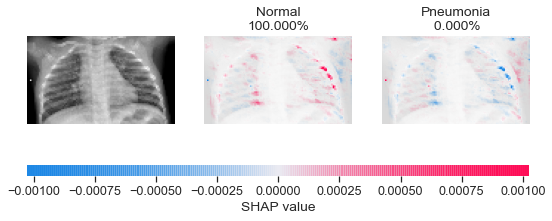

Predicted label :Pneumonia
True label :Normal


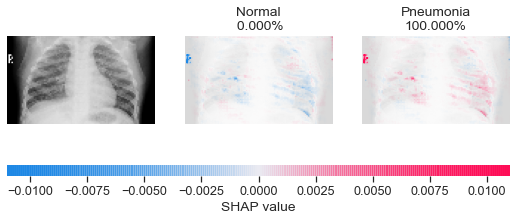

In [249]:
plot_SHAP_values(CNN_model, test_data, wrong_images, top_mistakes)

In [152]:
# TODO
# Elaborate on what we see in the images with the SHAP values above

### Second attempt

In [1]:
# load the varaiables
top_mistakes, wrong_images, wrong_pred_labels, true_labels, pred_dist = calc_SHAP_mistakes_values(CNN_condense_model, test_data, NN_test_labels)

plot_mistakes(top_mistakes, wrong_images, wrong_pred_labels, true_labels)

NameError: name 'calc_SHAP_mistakes_values' is not defined

In [ ]:
plot_SHAP_values(CNN_condense_model, test_data, wrong_images, top_mistakes)

### Last attempt

#### Data Transformations and Augmentation

In [23]:
# construct the training image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=10,
                             shear_range=.15,
                              zoom_range=.15,
                              width_shift_range=.15,
                              height_shift_range=.15,
                              horizontal_flip=True,
                              fill_mode='nearest')

### CNN with Data Generation

In [24]:
CNN_gen_model = Sequential()

CNN_gen_model.add(Conv2D(32, kernel_size = 4, activation="relu",padding='same', input_shape=(60,100,1)))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(64, kernel_size = 3, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Conv2D(128, kernel_size = 2, activation="relu", padding='same'))
CNN_gen_model.add(MaxPooling2D(pool_size=(2, 2)))

CNN_gen_model.add(Flatten())

CNN_gen_model.add(Dense(256, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(128, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(64, activation="relu"))
CNN_gen_model.add(Dropout(0.25))

CNN_gen_model.add(Dense(2, activation='softmax'))

CNN_gen_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 60, 100, 32)       544       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 50, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 25, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 25, 128)       32896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 12, 128)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10752)            

In [25]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
history = CNN_gen_model.fit(datagen.flow(train_data, NN_train_labels, batch_size=128 ),
                    epochs=100,
                    verbose=1,
                    shuffle=True,
                    validation_data=(valid_data, NN_valid_labels),
                    class_weight=weights_dict,
                    callbacks = [LR_reduce, ES_monitor])

Epoch 1/100
25/25 [==============================] - 33s 1s/step - loss: 0.6993 - accuracy: 0.5113 - val_loss: 0.6926 - val_accuracy: 0.4840
Epoch 2/100
25/25 [==============================] - 32s 1s/step - loss: 0.6559 - accuracy: 0.5107 - val_loss: 0.5332 - val_accuracy: 0.7816
Epoch 3/100
25/25 [==============================] - 30s 1s/step - loss: 0.5564 - accuracy: 0.7223 - val_loss: 0.4361 - val_accuracy: 0.7995
Epoch 4/100
25/25 [==============================] - 32s 1s/step - loss: 0.4673 - accuracy: 0.7689 - val_loss: 0.5458 - val_accuracy: 0.7407
Epoch 5/100
25/25 [==============================] - 30s 1s/step - loss: 0.3914 - accuracy: 0.8086 - val_loss: 0.4115 - val_accuracy: 0.8110
Epoch 6/100
25/25 [==============================] - 31s 1s/step - loss: 0.3490 - accuracy: 0.8412 - val_loss: 0.6850 - val_accuracy: 0.6820
Epoch 7/100
25/25 [==============================] - 30s 1s/step - loss: 0.3230 - accuracy: 0.8472 - val_loss: 0.4271 - val_accuracy: 0.7829
Epoch 8/100
2

In [27]:
plot_results(CNN_gen_model, test_data, NN_test_labels)

61/61 [==============================] - 5s 90ms/step - loss: 0.2106 - accuracy: 0.9243

The final results are:

Test loss: 21%
Test accuracy: 92%


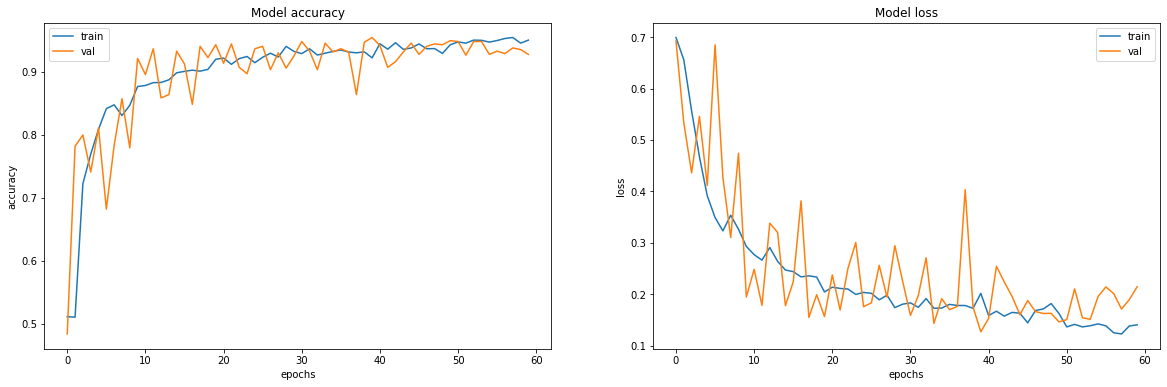

In [28]:
plot_history(history)

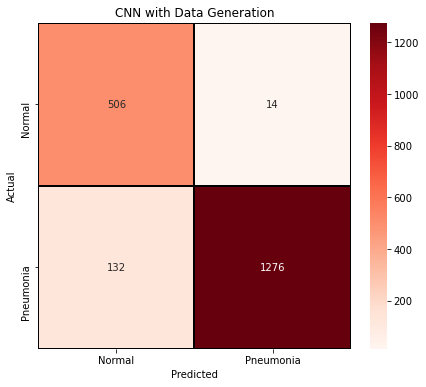

Normal accuracy test score: 97%
Pneumonia accuracy test score: 90%
Total accuracy test score: 92%


In [29]:
plot_NN_confusion_matrix(CNN_gen_model, test_data, NN_test_labels, "CNN with Data Generation")

# Conclusions

#### Results


In [ ]:
# TODO Table with all models NAive Bayes and NN to conclude all.
# one sentence of explanation of each method

## Self reflection/Discussion

In [154]:
# Did in this next part function for personal use, 
# mainly to observe how correct predictions looks with their SHAP values

### Function to test CORRECT predictions

In [117]:
# calculate the wrong predictions, distribution of answers by the model, top wrong predictions images
def calc_SHAP_correct_values(model, testing_data, testing_labels):
    
    pred = model.predict(testing_data)

    Y_pred_classes = np.argmax(pred,axis = 1) 
    Y_true = np.argmax(testing_labels,axis = 1)

    correct = (Y_pred_classes - Y_true != 1)

    correct_pred_labels = Y_pred_classes[correct]
    correct_pred_distribution = pred[correct]
#    true_labels = Y_true[errors]
    correct_images = testing_data[correct]


    Y_pred_errors_prob = np.max(correct_pred_distribution, axis = 1)
    true_prob_errors = np.diagonal(np.take(correct_pred_distribution, correct_pred_labels, axis=1))
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    top_mistakes = sorted_dela_errors[-NUM_OF_TOP_MISTAKES:]
    
    return top_mistakes, correct_images, correct_pred_labels, correct_pred_labels, correct_pred_distribution



# plot the wrong predictions
def plot_correct(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(20, 8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            
            if pred_errors[error] == 1:
                prediction = "Pneumonia"
            else:
                prediction = "Normal"
                
            if obs_errors[error] == 1:
                original = "Pneumonia"
            else:
                original = "Normal"
                
            ax[row,col].imshow((img_errors[error]).reshape((60,100)), cmap="gray")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(prediction,original))
            n += 1
    plt.show()
    
    
# plot the SHAP values of images with the answers probability    
def plot_SHAP_correct_values(model, testing_data, correct_pred, correct_pred_index):

    explainer = shap.DeepExplainer(model, (testing_data[0:100])) # amount of images to create background 
    
    conditions = ["Normal", "Pneumonia"]

    for i in correct_pred_index[:3]:     #Check out the 5 data that the model has correct predicted.
    
    #Calculates the SHAP value.
        shap_values = explainer.shap_values(correct_pred[[i]])
    
        if correct_pred_labels[i] == 1:
            prediction = "Pneumonia"
        else:
            prediction = "Normal"
    
        if correct_labels[i] == 1:
            original = "Pneumonia"
        else:
            original = "Normal"
        
        
        #calculate the answers probability
        index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format(correct_pred_dist[i][num]) for num, x in enumerate(conditions)]).reshape(1,2)
        print("Predicted label :{}\nTrue label :{}".format(prediction,original))
    
        #Displays the results.
        shap.image_plot(shap_values, correct_pred[[i]] ,index_names ,show=False)
        plt.show()

#### Testing SHAP values of correct predictions by our model

In [115]:
top_correct, correct_images, correct_pred_labels, correct_labels, correct_pred_dist = calc_SHAP_correct_values(model, test_data, test_labels)

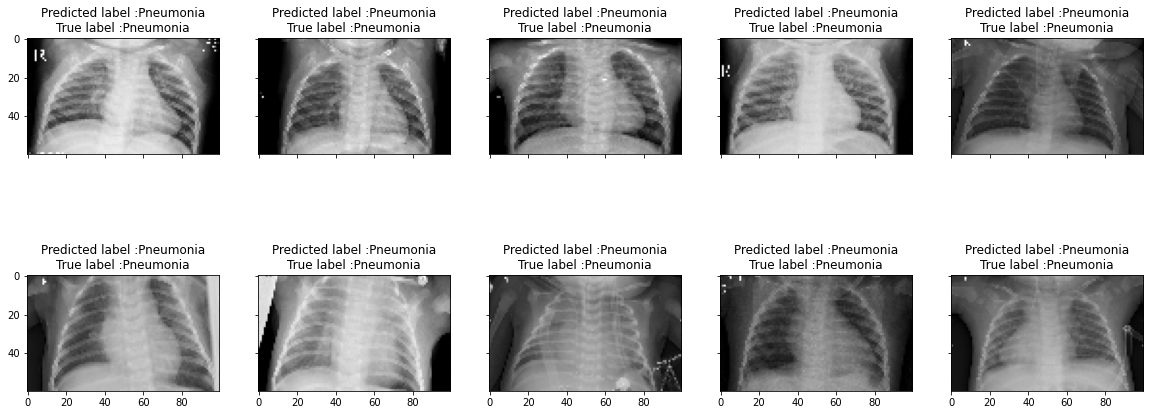

In [96]:
plot_correct(top_correct, correct_images, correct_pred_labels, correct_labels)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

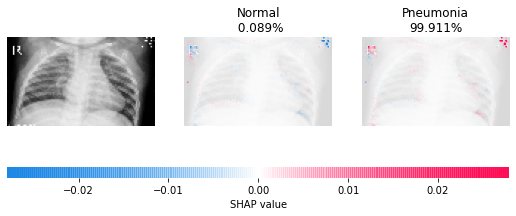

Predicted label :Pneumonia
True label :Pneumonia


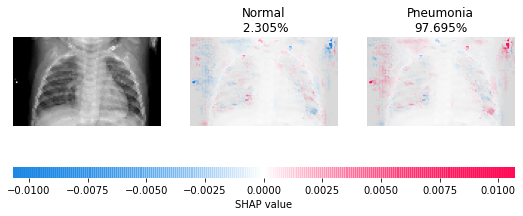

Predicted label :Pneumonia
True label :Pneumonia


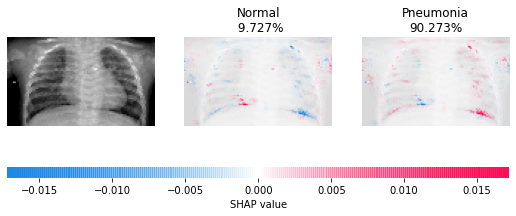

Wall time: 20 s


In [118]:
%%time
plot_SHAP_correct_values(model, test_data, correct_images, top_correct)

In [ ]:
## Elad's CNN - performed same as the rest of the models if not a bit worst, but took a full night to train.
# save it in case we will need some ideas..

In [97]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(5,5),activation='relu', input_shape=(60,100,1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(.25))

model.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(.25))


#model.add(Conv2D(128, kernel_size=(3,3),activation='relu', kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(Conv2D(256, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#model.add(Dropout(.25))

#model.add(Conv2D(128, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(Conv2D(256, kernel_size=(3,3),activation='relu',kernel_regularizer=regularizers.l2(reg)))
#model.add(BatchNormalization(axis=-1,center=True,scale=False))
#model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#model.add(Dropout(.25))

model.add(Flatten())
model.add(Dense(300,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(200,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization(axis=-1,center=True,scale=False))
model.add(Dropout(.25))
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 56, 96, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 96, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 52, 92, 128)       102528    
_________________________________________________________________
batch_normalization_1 (Batch (None, 52, 92, 128)       512       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 26, 46, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 26, 46, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 44, 32)       